## Data Update for 2024-06-10 export - Infilling up to five days

Notes for this script:

The only thing that needs to be adjusted each time this code is ran is the name of the data being read in and figure names. This can easily change these using command + F and searching the date associated with the file such as 06-10 or Jun10.

In this script I infill gaps missing 3,4, and 5 days of lat/lon:
1. When infilling three days of data, I choose to find any rows of data that are within five consecutive days (the day before, the three days missing data, and the day after). Once I have this, I infill any instances where the distance travelled in the missing day is less than 450 km, or the change in either latitude or longitude is less than 4 degrees.
2. When infilling four days of data, I choose to find any rows of data that are within six consecutive days (the day before, the four days missing data, and the day after). Once I have this, I infill any instances where the distance travelled in the missing day is less than 450 km, or the change in either latitude or longitude is less than 4 degrees.
3. When infilling five days of data, I choose to find any rows of data that are within seven consecutive days (the day before, the five days missing data, and the day after). Once I have this, I infill any instances where the distance travelled in the missing day is less than 450 km, or the change in either latitude or longitude is less than 4 degrees. 

These parameters were chosen in a different script where I analyzed the distribution of the spread of distances traveled/changes in latitude and longitude across all instances the rows found within consecutive days. These parameters change depending on how many days missing data we want to infill. As the number of days infilling increases, parameters do not change much. This may be due to the fact that when whalers actively pursued whales they stayed in relatively the same position and often forgot to note their logs for the day. 

Infilling is done in three steps:

1. Find rows missing one day of both latitude and longitude with the surrounding days having values. Find the distance that would be travelled over the missing day using the values from the day before and after. Infill by interpolating values for the gap (similar to finding the mid point) again using the day before and the day after.
2. Find rows in the latitude column just missing one day with the surrounding days having latitude values. Find the difference in latitude between the day before and day after. Infill using interpolation.
3. Find rows in the longitude column just missing one day with the surrounding days having longitude values. Find the difference in longitude between the day before and day after. Infill using interpolation.

In [1]:
# Import
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime, os
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import seaborn as sns
from tabulate import tabulate
import sys
from matplotlib.colors import Normalize
from geopy.distance import geodesic
from scipy import stats

pd.options.display.max_columns = 50

print("Last updated on {}".format(datetime.datetime.now().ctime()))

Last updated on Wed Jun 12 10:40:53 2024


In [2]:
# Import tier 3 Data
df = pd.read_pickle("Tier3_logentries-export-2024-06-10.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96383 entries, 12264 to 21835
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   DateTime                    96378 non-null  object        
 1   ID                          96380 non-null  float64       
 2   LogBook ID                  96379 non-null  object        
 3   Page                        59413 non-null  float64       
 4   Latitude                    77620 non-null  float64       
 5   Longitude                   68246 non-null  float64       
 6   Infilled                    96383 non-null  bool          
 7   Depth                       2134 non-null   float64       
 8   Depth Unit                  22937 non-null  object        
 9   Bottom                      63 non-null     object        
 10  Landmark                    15197 non-null  object        
 11  Ship Heading/Course         53219 non-null  object     

In [3]:
# Setting up a folder system 
# Create folders called "Figures" and "Text/CSV Files" manually (right click + new folder on left side)

# Get current directory
current_directory = os.getcwd()

# Specify the path to the folder
Figures = os.path.join(current_directory, 'Figures')
Files = os.path.join(current_directory, 'Text Files')
CSV = os.path.join(current_directory, 'CSV Files')

In [4]:
# This step is done in the cleaning Tier 1-3 scripts, so may not be needed again, but just in case

# Sorting data by logbook ID, date, and landmark
# Create a unique separator that does not appear in data
separator = '###'

# Replace consecutive spaces with the separator in the 'Landmark' column
df['Landmark'] = df['Landmark'].str.replace(r'\s+', separator, regex=True)

# Sort the DataFrame
df = df.sort_values(by=['LogBook ID', 'DateTime', 'Landmark'])

# Replace the separator with a single space
df['Landmark'] = df['Landmark'].str.replace(separator, ' ')

In [5]:
#Creating a dataframe of usable data
df['usable'] = (df["Latitude"].notna() & df["Longitude"].notna() & df["Wind Force"].notna())
df_u = df[df['usable']==True]
df_u

,DateTime,ID,LogBook ID,Page,Latitude,Longitude,Infilled,Depth,Depth Unit,Bottom,Landmark,Ship Heading/Course,Wind Direction,Wind Speed/Force,Wind Force,Sea State,Cloud Cover,Weather,Ship Sightings,Miscellaneous Observations,wind force,Entry Date Time,Direction,Wind Direction Before,coord_diff,usable,usable_latlon,usable_lat,One Day Dist,One Day Lat,One Day Lon,Tier2_usable,Tier2_new,Two Day Dist,Tier 3 Infilled,Two Day Lat,Two Day Lon,Tier3_usable,Tier3_new
96400,1853-07-06 12:00:00,2442.0,A. Houghton (bark) 1853-1857,NaN,37.850000,-58.466667,False,NaN,NaN,NaN,NaN,SE,225.0,moderate gales,7.0,NaN,NaN,NaN,NaN,NaN,False,1853-07-06 12:00:00,nan,SW,False,True,True,True,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False
96398,1853-07-07 12:00:00,2443.0,A. Houghton (bark) 1853-1857,NaN,37.250000,-55.066667,False,NaN,NaN,NaN,NaN,NaN,225.0,fresh breezes,5.0,NaN,NaN,NaN,NaN,NaN,False,1853-07-07 12:00:00,nan,SW,False,True,True,True,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False
96396,1853-07-09 12:00:00,2446.0,A. Houghton (bark) 1853-1857,NaN,33.750000,-52.466667,False,NaN,NaN,NaN,NaN,SSE,225.0,light,2.0,NaN,NaN,fine,NaN,NaN,False,1853-07-09 12:00:00,nan,SW,False,True,True,True,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False
96395,1853-07-10 12:00:00,2447.0,A. Houghton (bark) 1853-1857,NaN,33.333333,-53.716667,False,NaN,NaN,NaN,NaN,S,NaN,light airs,1.0,calms,NaN,NaN,NaN,NaN,False,1853-07-10 12:00:00,nan,NaN,False,True,True,True,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False
96393,1853-07-12 12:00:00,2449.0,A. Houghton (bark) 1853-1857,NaN,33.816667,-53.066667,False,NaN,NaN,NaN,NaN,NaN,135.0,moderate winds,4.0,NaN,NaN,clear,NaN,NaN,False,1853-07-12 12:00:00,nan,SE,False,True,True,True,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1837-01-06 12:00:00,101316.0,Young Phenix (ship) 1836-1840,NaN,18.266667,-23.616667,False,NaN,fathoms,NaN,NaN,S,22.5,small breezes,2.0,NaN,NaN,fine,NaN,NaN,False,1837-01-06 12:00:00,nan,NNE,False,True,True,True,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False
56,1837-01-07 12:00:00,101317.0,Young Phenix (ship) 1836-1840,NaN,16.466667,-23.050000,False,NaN,fathoms,NaN,NaN,S by E,45.0,strong trades,6.0,NaN,NaN,NaN,NaN,NaN,False,1837-01-07 12:00:00,nan,NE,False,True,True,True,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False
55,1837-01-08 12:00:00,101318.0,Young Phenix (ship) 1836-1840,NaN,14.433333,-23.900000,False,NaN,fathoms,NaN,NaN,SW by S,NaN,strong trade,6.0,NaN,clear,NaN,NaN,NaN,False,1837-01-08 12:00:00,nan,NaN,False,True,True,True,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False
54,1837-01-09 12:00:00,101319.0,Young Phenix (ship) 1836-1840,NaN,11.650000,-22.733333,False,NaN,fathoms,NaN,NaN,S,NaN,strong trade,6.0,NaN,passing clouds,NaN,NaN,NaN,False,1837-01-09 12:00:00,nan,NaN,False,True,True,True,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False


# Taking the clean data and infilling where three days of data are missing

### Infilling missing latitude and longitude

In [6]:
# Finding distance traveled in instances of five consecutive days 
# We need five consecutive days to find the three missing days, the day before and the day after

# Sort the DataFrame by 'LogBook ID' and 'DateTime'
df_sorted = df.sort_values(by=['LogBook ID', 'DateTime'])

# Initialize the new column
df_sorted['Three Day Dist'] = np.nan

# Function to check if dates are consecutive
def are_consecutive_dates(date_above, date_one, date_two, date_three, date_below):
    if all(pd.notna(date) for date in [date_above, date_one, date_two, date_three, date_below]):
        # Check if dates are consecutive
        return (date_one - date_above).days == 1 and \
               (date_two - date_one).days == 1 and \
               (date_three - date_two).days == 1 and \
               (date_below - date_three).days == 1
    return False

# Iterate through the sorted DataFrame to check for the conditions
for i in range(2, len(df_sorted) - 2):  # Start from the third row and end before last rows
    if (np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Longitude')]) and np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Longitude')]) and np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 2, df_sorted.columns.get_loc('Longitude')]) and np.isnan(df_sorted.iloc[i + 2, df_sorted.columns.get_loc('Latitude')])):
        # Check if both Longitude and Latitude are NaN in the current row, and the next row
        if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]) or np.isnan(df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Longitude')])):
            # Check if Longitude in both previous and next rows are not NaN
            if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')]) or np.isnan(df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Latitude')])):
                # Check if Latitude in both previous and next rows are not NaN
                date_above = pd.to_datetime(df_sorted.iloc[i - 1]['DateTime']).date()
                date_one = pd.to_datetime(df_sorted.iloc[i]['DateTime']).date()
                date_two = pd.to_datetime(df_sorted.iloc[i + 1]['DateTime']).date()
                date_three = pd.to_datetime(df_sorted.iloc[i + 2]['DateTime']).date()
                date_below = pd.to_datetime(df_sorted.iloc[i + 3]['DateTime']).date()

                if are_consecutive_dates(date_above, date_one, date_two, date_three, date_below):
                    # Check if dates are consecutive
                    
                    # Calculate distance for each consecutive pair of points
                    latitude1, longitude1 = df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')], df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]
                    latitude2, longitude2 = df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Latitude')], df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Longitude')]
                    distance = geodesic((latitude1, longitude1), (latitude2, longitude2)).kilometers

                    # Update the 'Three Day Dist' column, only for the first day missing values not all 3
                    df_sorted.at[df_sorted.index[i], 'Three Day Dist'] = distance

# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Three Day Dist']])

# Saving data to a CSV file
df['Three Day Dist'] = df_sorted['Three Day Dist']
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)


                  DateTime   Latitude  Longitude  Three Day Dist
12264                  4.5        NaN        NaN             NaN
12266                   10        NaN        NaN             NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667             NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667             NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000             NaN
...                    ...        ...        ...             ...
53     1837-01-10 12:00:00   8.733333 -21.933333             NaN
570                    NaN        NaN        NaN             NaN
5817                   NaN        NaN        NaN             NaN
12270                  NaN        NaN        NaN             NaN
21835                  NaN        NaN        NaN             NaN

[96383 rows x 4 columns]


In [7]:
# Interpolate missing lat and lon for distances less than 450 km

# Iterate over the DataFrame index to find rows with 'Three Day Dist' less than 450.00
for i in range(len(df_sorted)):  # Avoid index out of bounds
    if i == 0 or i >= len(df_sorted) - 2:
        continue  # Skip first and last rows

    if df_sorted.at[df_sorted.index[i], 'Three Day Dist'] < 450.01:
        # Select rows between i-1 and i+3
        selected_rows = df_sorted.iloc[i-1:i+4][['Latitude', 'Longitude']]

        # Interpolate between where the condition is met
        
        # Handle longitude wrap-around for interpolation
        # First value is negative (west) and last value is positive (east): ex. -179 to 179
        if selected_rows.iloc[0]['Longitude'] < -170 and selected_rows.iloc[-1]['Longitude'] > 170:
            selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x <= 0 else x - 360)
            interpolated_values = selected_rows.interpolate(method='linear')
            interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x >= -180 else x + 360)
        # First value is positive (east) and second value is negative (west): ex. 179 to -179
        elif selected_rows.iloc[0]['Longitude'] > 170 and selected_rows.iloc[-1]['Longitude'] < -170:
            selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x >= 0 else x + 360)
            interpolated_values = selected_rows.interpolate(method='linear')
            interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x <= -180 else x - 360)
        # Interpolate all other data gaps
        else:
            interpolated_values = selected_rows.interpolate(method='linear')

        # Assign interpolated values to Latitude and Longitude columns for i and i+1
        df.at[df_sorted.index[i], 'Latitude'] = interpolated_values.iloc[1]['Latitude']
        df.at[df_sorted.index[i], 'Longitude'] = interpolated_values.iloc[1]['Longitude']

        df.at[df_sorted.index[i+1], 'Latitude'] = interpolated_values.iloc[2]['Latitude']
        df.at[df_sorted.index[i+1], 'Longitude'] = interpolated_values.iloc[2]['Longitude']

        df.at[df_sorted.index[i+2], 'Latitude'] = interpolated_values.iloc[3]['Latitude']
        df.at[df_sorted.index[i+2], 'Longitude'] = interpolated_values.iloc[3]['Longitude']

        # Mark the overall infilled column as true
        df.at[df_sorted.index[i], 'Infilled'] = True
        df.at[df_sorted.index[i+1], 'Infilled'] = True
        df.at[df_sorted.index[i+2], 'Infilled'] = True

        # Mark the new tier 4 infilled column as true
        df.at[df_sorted.index[i], 'Tier 4 Infilled'] = True
        df.at[df_sorted.index[i+1], 'Tier 4 Infilled'] = True
        df.at[df_sorted.index[i+2], 'Tier 4 Infilled'] = True

        # Mark the new 3 days infilled column as true
        df.at[df_sorted.index[i], 'Day 3 Infilled'] = True
        df.at[df_sorted.index[i+1], 'Day 3 Infilled'] = True
        df.at[df_sorted.index[i+2], 'Day 3 Infilled'] = True

# Print the DataFrame to verify the new columns
print(df[['DateTime', 'Latitude', 'Longitude', 'Three Day Dist']])

# Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)


/tmp/ipykernel_604910/3538722379.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[df_sorted.index[i], 'Tier 4 Infilled'] = True
/tmp/ipykernel_604910/3538722379.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[df_sorted.index[i], 'Day 3 Infilled'] = True


                  DateTime   Latitude  Longitude  Three Day Dist
12264                  4.5        NaN        NaN             NaN
12266                   10        NaN        NaN             NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667             NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667             NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000             NaN
...                    ...        ...        ...             ...
53     1837-01-10 12:00:00   8.733333 -21.933333             NaN
570                    NaN        NaN        NaN             NaN
5817                   NaN        NaN        NaN             NaN
12270                  NaN        NaN        NaN             NaN
21835                  NaN        NaN        NaN             NaN

[96383 rows x 4 columns]


In [8]:
# Count the number of values infilled so far
num_infilled = df['Infilled'].sum()

print("Total number of new values added to the latitude and longitude columns:", num_infilled)

Total number of new values added to the latitude and longitude columns: 8608


### Infilling three days just latitude

In [9]:
# Finding three days of latitude missing in instances of five consecutive days 
# and taking the change in latitude to see travel distance
# Similar process as above, but only for the latitude column

# Initialize the new column
df_sorted['Three Day Lat'] = np.nan

# Function to check if dates are consecutive
def are_consecutive_dates(date_above, date_one, date_two, date_three, date_below):
    if all(pd.notna(date) for date in [date_above, date_one, date_two, date_three, date_below]):
        # Check if dates are consecutive
        return (date_one - date_above).days == 1 and \
               (date_two - date_one).days == 1 and \
               (date_three - date_two).days == 1 and \
               (date_below - date_three).days == 1
    return False
    
# Iterate through the sorted DataFrame to check for the conditions
for i in range(2, len(df_sorted) - 2):  # Start from the third row and end before last rows
    if (np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 2, df_sorted.columns.get_loc('Latitude')])):
        # Check if Latitude is NaN in the current row, and the next row
        if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')]) or np.isnan(df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Latitude')])):
            # Check if latitude in both previous and next rows are not NaN
                date_above = pd.to_datetime(df_sorted.iloc[i - 1]['DateTime']).date()
                date_one = pd.to_datetime(df_sorted.iloc[i]['DateTime']).date()
                date_two = pd.to_datetime(df_sorted.iloc[i + 1]['DateTime']).date()
                date_three = pd.to_datetime(df_sorted.iloc[i + 2]['DateTime']).date()
                date_below = pd.to_datetime(df_sorted.iloc[i + 3]['DateTime']).date()

                if are_consecutive_dates(date_above, date_one, date_two, date_three, date_below):
                    # Check if dates are consecutive
                    
                    # Calculate change in lat for each consecutive pair of points
                    latitude1 = df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')]
                    latitude2 = df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Latitude')]
                    distance = latitude1-latitude2
                
                    # Update the 'Three Day Lat' column, only for the first day missing values not all 3
                    df_sorted.at[df_sorted.index[i], 'Three Day Lat'] = distance

# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Three Day Lat']]) 
df['Three Day Lat'] = df_sorted['Three Day Lat']

#Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)


                  DateTime   Latitude  Longitude  Three Day Lat
12264                  4.5        NaN        NaN            NaN
12266                   10        NaN        NaN            NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667            NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667            NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000            NaN
...                    ...        ...        ...            ...
53     1837-01-10 12:00:00   8.733333 -21.933333            NaN
570                    NaN        NaN        NaN            NaN
5817                   NaN        NaN        NaN            NaN
12270                  NaN        NaN        NaN            NaN
21835                  NaN        NaN        NaN            NaN

[96383 rows x 4 columns]


In [10]:
# Filling in days where latitude difference is less than 4 degrees

# Iterate over the DataFrame index to find rows with 'Three Day Lat' less than 4.00
for i in range(len(df_sorted)):
    if i == 0 or i >= len(df_sorted) - 2:
        continue  # Skip first and last rows

    if -4.01 < df_sorted.at[df_sorted.index[i], 'Three Day Lat'] < 4.01:
        # Check if latitude is already filled
        if pd.notna(df_sorted.at[df_sorted.index[i], 'Latitude']):
            continue
        else:
            # Select rows between i-1 and i+3
            selected_rows = df_sorted.iloc[i-1:i+4][['Latitude', 'Longitude']]
        
            # Interpolate between where the condition is met
            interpolated_values = selected_rows.interpolate(method='linear')

            # Assign interpolated values to New Latitude and New Longitude columns for i to i+2
            df.at[df_sorted.index[i], 'Latitude'] = interpolated_values.iloc[1]['Latitude']
            df.at[df_sorted.index[i+1], 'Latitude'] = interpolated_values.iloc[2]['Latitude']
            df.at[df_sorted.index[i+2], 'Latitude'] = interpolated_values.iloc[3]['Latitude']

            # Mark the overall infilled column as true
            df.at[df_sorted.index[i], 'Infilled'] = True
            df.at[df_sorted.index[i+1], 'Infilled'] = True
            df.at[df_sorted.index[i+2], 'Infilled'] = True

            # Mark the new tier 4 infilled column as true
            df.at[df_sorted.index[i], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+1], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+2], 'Tier 4 Infilled'] = True

            # Mark the new three days infilled column as true
            df.at[df_sorted.index[i], 'Day 3 Infilled'] = True
            df.at[df_sorted.index[i+1], 'Day 3 Infilled'] = True
            df.at[df_sorted.index[i+2], 'Day 3 Infilled'] = True
        
# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Three Day Lat']])

# Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)


                  DateTime   Latitude  Longitude  Three Day Lat
12264                  4.5        NaN        NaN            NaN
12266                   10        NaN        NaN            NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667            NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667            NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000            NaN
...                    ...        ...        ...            ...
53     1837-01-10 12:00:00   8.733333 -21.933333            NaN
570                    NaN        NaN        NaN            NaN
5817                   NaN        NaN        NaN            NaN
12270                  NaN        NaN        NaN            NaN
21835                  NaN        NaN        NaN            NaN

[96383 rows x 4 columns]


In [11]:
# Count the number of values infilled so far
num_infilled = df['Infilled'].sum()

print("Total number of new values added to the latitude and longitude columns:", num_infilled)

Total number of new values added to the latitude and longitude columns: 9218


### Infilling three days just longitude

In [12]:
# Finding three days of longitude missing in instances of five consecutive days 
# and taking the change in latitude to see travel distance
# Similar process as above, but only for the longitude column

# Initialize the new column
df_sorted['Three Day Lon'] = np.nan

# Function to check if dates are consecutive
def are_consecutive_dates(date_above, date_one, date_two, date_three, date_below):
    if all(pd.notna(date) for date in [date_above, date_one, date_two, date_three, date_below]):
        # Check if dates are consecutive
        return (date_one - date_above).days == 1 and \
               (date_two - date_one).days == 1 and \
               (date_three - date_two).days == 1 and \
               (date_below - date_three).days == 1
    return False
    
# Iterate through the sorted DataFrame to check for the conditions
for i in range(2, len(df_sorted) - 2):  # Start from the third row and end before last rows
    if (np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Longitude')])) and \
       (np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Longitude')])) and \
       (np.isnan(df_sorted.iloc[i + 2, df_sorted.columns.get_loc('Longitude')])):
        # Check if Longitude is NaN in the current row, and the next row
        if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]) or np.isnan(df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Longitude')])):
            # Check if Longitude in both previous and next rows are not NaN
            date_above = pd.to_datetime(df_sorted.iloc[i - 1]['DateTime']).date()
            date_one = pd.to_datetime(df_sorted.iloc[i]['DateTime']).date()
            date_two = pd.to_datetime(df_sorted.iloc[i + 1]['DateTime']).date()
            date_three = pd.to_datetime(df_sorted.iloc[i + 2]['DateTime']).date()
            date_below = pd.to_datetime(df_sorted.iloc[i + 3]['DateTime']).date()

            if are_consecutive_dates(date_above, date_one, date_two, date_three, date_below):
                # Check if dates are consecutive
               
                # Calculate change in lon for each consecutive pair of points
                longitude1 = df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]
                longitude2 = df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Longitude')]

                # Calculate the raw difference
                raw_difference = longitude1 - longitude2

                # Define the threshold for crossing over 175°E or -175°
                threshold = 175

                # Adjust the raw difference if it crosses over the threshold
                if (longitude1 > threshold and longitude2 < -threshold) or (longitude1 < -threshold and longitude2 > threshold):
                    if raw_difference > 0:
                        distance = raw_difference - 360
                    else:
                        distance = raw_difference + 360
                else:
                    distance = raw_difference

                # Update the 'Three Day Lon' column, only for the first day missing values not all 3
                df_sorted.at[df_sorted.index[i], 'Three Day Lon'] = distance

# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Three Day Lon']])
df['Three Day Lon'] = df_sorted['Three Day Lon']

#Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)


                  DateTime   Latitude  Longitude  Three Day Lon
12264                  4.5        NaN        NaN            NaN
12266                   10        NaN        NaN            NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667            NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667            NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000            NaN
...                    ...        ...        ...            ...
53     1837-01-10 12:00:00   8.733333 -21.933333            NaN
570                    NaN        NaN        NaN            NaN
5817                   NaN        NaN        NaN            NaN
12270                  NaN        NaN        NaN            NaN
21835                  NaN        NaN        NaN            NaN

[96383 rows x 4 columns]


In [13]:
# Filling in days where longitude difference is less than 4 degrees

# Iterate over the DataFrame index to find rows with 'Three Day Lon' less than 4.00
for i in range(len(df_sorted)):
    if i == 0 or i >= len(df_sorted) - 2:
        continue  # Skip first and last rows

    if -4.01 < df_sorted.at[df_sorted.index[i], 'Three Day Lon'] < 4.01:
        # Check if New Longitude is already filled
        if pd.notna(df_sorted.at[df_sorted.index[i], 'Longitude']):
            continue
        else:
            # Select rows between i-1 and i+3
            selected_rows = df_sorted.iloc[i-1:i+4][['Latitude', 'Longitude']]

            # Interpolate between where the condition is met
        
            # Handle longitude wrap-around for interpolation
            # First value is negative (west) and last value is positive (east): ex. -179 to 179
            if selected_rows.iloc[0]['Longitude'] < -170 and selected_rows.iloc[-1]['Longitude'] > 170:
                selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x <= 0 else x - 360)
                interpolated_values = selected_rows.interpolate(method='linear')
                interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x >= -180 else x + 360)
            # First value is positive (east) and second value is negative (west): ex. 179 to -179
            elif selected_rows.iloc[0]['Longitude'] > 170 and selected_rows.iloc[-1]['Longitude'] < -170:
                selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x >= 0 else x + 360)
                interpolated_values = selected_rows.interpolate(method='linear')
                interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x <= -180 else x - 360)
            # Interpolate all other data gaps
            else:
                interpolated_values = selected_rows.interpolate(method='linear')

            # Assign interpolated values to longitude column for i to i+2
            df.at[df_sorted.index[i], 'Longitude'] = interpolated_values.iloc[1]['Longitude']
            df.at[df_sorted.index[i+1], 'Longitude'] = interpolated_values.iloc[2]['Longitude']
            df.at[df_sorted.index[i+2], 'Longitude'] = interpolated_values.iloc[3]['Longitude']

            # Mark the overall infilled column as true
            df.at[df_sorted.index[i], 'Infilled'] = True
            df.at[df_sorted.index[i+1], 'Infilled'] = True
            df.at[df_sorted.index[i+2], 'Infilled'] = True

            # Mark the new tier 4 infilled column as true
            df.at[df_sorted.index[i], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+1], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+2], 'Tier 4 Infilled'] = True

            # Mark the new three days infilled column as true
            df.at[df_sorted.index[i], 'Day 3 Infilled'] = True
            df.at[df_sorted.index[i+1], 'Day 3 Infilled'] = True
            df.at[df_sorted.index[i+2], 'Day 3 Infilled'] = True

# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Three Day Lon']])

# Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)


                  DateTime   Latitude  Longitude  Three Day Lon
12264                  4.5        NaN        NaN            NaN
12266                   10        NaN        NaN            NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667            NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667            NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000            NaN
...                    ...        ...        ...            ...
53     1837-01-10 12:00:00   8.733333 -21.933333            NaN
570                    NaN        NaN        NaN            NaN
5817                   NaN        NaN        NaN            NaN
12270                  NaN        NaN        NaN            NaN
21835                  NaN        NaN        NaN            NaN

[96383 rows x 4 columns]


In [14]:
# Count the number of values infilled so far
num_infilled = df['Infilled'].sum()

print("Total number of new values added to the latitude and longitude columns:", num_infilled)

Total number of new values added to the latitude and longitude columns: 10052


# Infilling where four days of data are missing

### Infilling missing latitude and longitude

In [15]:
# Finding distance traveled in instances of six consecutive days 
# We need six consecutive days to find the four missing days, the day before and the day after

# Sort the DataFrame by 'LogBook ID' and 'DateTime'
df_sorted = df.sort_values(by=['LogBook ID', 'DateTime'])

# Initialize the new column
df_sorted['Four Day Dist'] = np.nan

# Function to check if dates are consecutive
def are_consecutive_dates(date_above, date_one, date_two, date_three, date_four, date_below):
    if all(pd.notna(date) for date in [date_above, date_one, date_two, date_three, date_four, date_below]):
        # Check if dates are consecutive
        return (date_one - date_above).days == 1 and \
               (date_two - date_one).days == 1 and \
               (date_three - date_two).days == 1 and \
               (date_four - date_three).days == 1 and \
               (date_below - date_four).days == 1
    return False

# Iterate through the sorted DataFrame to check for the conditions
for i in range(2, len(df_sorted) - 4):  # Start from the third row and end before last rows
    if (np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Longitude')]) and np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Longitude')]) and np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 2, df_sorted.columns.get_loc('Longitude')]) and np.isnan(df_sorted.iloc[i + 2, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Longitude')]) and np.isnan(df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Latitude')])):
        # Check if both Longitude and Latitude are NaN in the current row, and the next row
        if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]) or np.isnan(df_sorted.iloc[i + 4, df_sorted.columns.get_loc('Longitude')])):
            # Check if Longitude in both previous and next rows are not NaN
            if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')]) or np.isnan(df_sorted.iloc[i + 4, df_sorted.columns.get_loc('Latitude')])):
                # Check if Latitude in both previous and next rows are not NaN
                date_above = pd.to_datetime(df_sorted.iloc[i - 1]['DateTime']).date()
                date_one = pd.to_datetime(df_sorted.iloc[i]['DateTime']).date()
                date_two = pd.to_datetime(df_sorted.iloc[i + 1]['DateTime']).date()
                date_three = pd.to_datetime(df_sorted.iloc[i + 2]['DateTime']).date()
                date_four = pd.to_datetime(df_sorted.iloc[i + 3]['DateTime']).date()
                date_below = pd.to_datetime(df_sorted.iloc[i + 4]['DateTime']).date()

                if are_consecutive_dates(date_above, date_one, date_two, date_three, date_four, date_below):
                    # Check if dates are consecutive
                    
                    # Calculate distance for each consecutive pair of points
                    latitude1, longitude1 = df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')], df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]
                    latitude2, longitude2 = df_sorted.iloc[i + 4, df_sorted.columns.get_loc('Latitude')], df_sorted.iloc[i + 4, df_sorted.columns.get_loc('Longitude')]
                    distance = geodesic((latitude1, longitude1), (latitude2, longitude2)).kilometers

                    # Update the 'Four Day Dist' column, only for the first day missing values not all 4
                    df_sorted.at[df_sorted.index[i], 'Four Day Dist'] = distance

# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Four Day Dist']])

# Saving data to a CSV file
df['Four Day Dist'] = df_sorted['Four Day Dist']
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)


                  DateTime   Latitude  Longitude  Four Day Dist
12264                  4.5        NaN        NaN            NaN
12266                   10        NaN        NaN            NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667            NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667            NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000            NaN
...                    ...        ...        ...            ...
53     1837-01-10 12:00:00   8.733333 -21.933333            NaN
570                    NaN        NaN        NaN            NaN
5817                   NaN        NaN        NaN            NaN
12270                  NaN        NaN        NaN            NaN
21835                  NaN        NaN        NaN            NaN

[96383 rows x 4 columns]


In [16]:
# Interpolate missing lat and lon for distances less than 450 km

# Iterate over the DataFrame index to find rows with 'Four Day Dist' less than 450.00
for i in range(len(df_sorted)):  # Avoid index out of bounds
    if i == 0 or i >= len(df_sorted) - 2:
        continue  # Skip first and last rows

    if df_sorted.at[df_sorted.index[i], 'Four Day Dist'] < 450.01:
        # Select rows between i-1 and i+5
        selected_rows = df_sorted.iloc[i-1:i+5][['Latitude', 'Longitude']]

        # Interpolate between where the condition is met
        
        # Handle longitude wrap-around for interpolation
        # First value is negative (west) and last value is positive (east): ex. -179 to 179
        if selected_rows.iloc[0]['Longitude'] < -170 and selected_rows.iloc[-1]['Longitude'] > 170:
            selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x <= 0 else x - 360)
            interpolated_values = selected_rows.interpolate(method='linear')
            interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x >= -180 else x + 360)
        # First value is positive (east) and second value is negative (west): ex. 179 to -179
        elif selected_rows.iloc[0]['Longitude'] > 170 and selected_rows.iloc[-1]['Longitude'] < -170:
            selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x >= 0 else x + 360)
            interpolated_values = selected_rows.interpolate(method='linear')
            interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x <= -180 else x - 360)
        # Interpolate all other data gaps
        else:
            interpolated_values = selected_rows.interpolate(method='linear')

        # Assign interpolated values to Latitude and Longitude columns for i to i+3
        df.at[df_sorted.index[i], 'Latitude'] = interpolated_values.iloc[1]['Latitude']
        df.at[df_sorted.index[i], 'Longitude'] = interpolated_values.iloc[1]['Longitude']

        df.at[df_sorted.index[i+1], 'Latitude'] = interpolated_values.iloc[2]['Latitude']
        df.at[df_sorted.index[i+1], 'Longitude'] = interpolated_values.iloc[2]['Longitude']

        df.at[df_sorted.index[i+2], 'Latitude'] = interpolated_values.iloc[3]['Latitude']
        df.at[df_sorted.index[i+2], 'Longitude'] = interpolated_values.iloc[3]['Longitude']

        df.at[df_sorted.index[i+3], 'Latitude'] = interpolated_values.iloc[4]['Latitude']
        df.at[df_sorted.index[i+3], 'Longitude'] = interpolated_values.iloc[4]['Longitude']

        # Mark the overall infilled column as true
        df.at[df_sorted.index[i], 'Infilled'] = True
        df.at[df_sorted.index[i+1], 'Infilled'] = True
        df.at[df_sorted.index[i+2], 'Infilled'] = True
        df.at[df_sorted.index[i+3], 'Infilled'] = True

        # Mark the new tier 4 infilled column as true
        df.at[df_sorted.index[i], 'Tier 4 Infilled'] = True
        df.at[df_sorted.index[i+1], 'Tier 4 Infilled'] = True
        df.at[df_sorted.index[i+2], 'Tier 4 Infilled'] = True
        df.at[df_sorted.index[i+3], 'Tier 4 Infilled'] = True

        # Mark the new four days infilled column as true
        df.at[df_sorted.index[i], 'Day 4 Infilled'] = True
        df.at[df_sorted.index[i+1], 'Day 4 Infilled'] = True
        df.at[df_sorted.index[i+2], 'Day 4 Infilled'] = True
        df.at[df_sorted.index[i+3], 'Day 4 Infilled'] = True

# Print the DataFrame to verify the new columns
print(df[['DateTime', 'Latitude', 'Longitude', 'Four Day Dist']])

# Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)


/tmp/ipykernel_604910/2229321404.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[df_sorted.index[i], 'Day 4 Infilled'] = True


                  DateTime   Latitude  Longitude  Four Day Dist
12264                  4.5        NaN        NaN            NaN
12266                   10        NaN        NaN            NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667            NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667            NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000            NaN
...                    ...        ...        ...            ...
53     1837-01-10 12:00:00   8.733333 -21.933333            NaN
570                    NaN        NaN        NaN            NaN
5817                   NaN        NaN        NaN            NaN
12270                  NaN        NaN        NaN            NaN
21835                  NaN        NaN        NaN            NaN

[96383 rows x 4 columns]


In [17]:
# Count the number of values infilled so far
num_infilled = df['Infilled'].sum()

print("Total number of new values added to the latitude and longitude columns:", num_infilled)

Total number of new values added to the latitude and longitude columns: 10356


### Infilling four days just latitude

In [18]:
# Finding four days of latitude missing in instances of six consecutive days 
# and taking the change in latitude to see travel distance
# Similar process as above, but only for the latitude column

# Initialize the new column
df_sorted['Four Day Lat'] = np.nan

# Function to check if dates are consecutive
def are_consecutive_dates(date_above, date_one, date_two, date_three, date_four, date_below):
    if all(pd.notna(date) for date in [date_above, date_one, date_two, date_three, date_four, date_below]):
        # Check if dates are consecutive
        return (date_one - date_above).days == 1 and \
               (date_two - date_one).days == 1 and \
               (date_three - date_two).days == 1 and \
               (date_four - date_three).days == 1 and \
               (date_below - date_four).days == 1
    return False
    
# Iterate through the sorted DataFrame to check for the conditions
for i in range(2, len(df_sorted) - 4):  # Start from the third row and end before last rows
    if (np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 2, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Latitude')])):
        # Check if Latitude is NaN in the current row, and the next row
        if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')]) or np.isnan(df_sorted.iloc[i + 4, df_sorted.columns.get_loc('Latitude')])):
            # Check if latitude in both previous and next rows are not NaN
                date_above = pd.to_datetime(df_sorted.iloc[i - 1]['DateTime']).date()
                date_one = pd.to_datetime(df_sorted.iloc[i]['DateTime']).date()
                date_two = pd.to_datetime(df_sorted.iloc[i + 1]['DateTime']).date()
                date_three = pd.to_datetime(df_sorted.iloc[i + 2]['DateTime']).date()
                date_four = pd.to_datetime(df_sorted.iloc[i + 3]['DateTime']).date()
                date_below = pd.to_datetime(df_sorted.iloc[i + 4]['DateTime']).date()

                if are_consecutive_dates(date_above, date_one, date_two, date_three, date_four, date_below):
                    # Check if dates are consecutive
                    
                    # Calculate change in lat for each consecutive pair of points
                    latitude1 = df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')]
                    latitude2 = df_sorted.iloc[i + 4, df_sorted.columns.get_loc('Latitude')]
                    distance = latitude1-latitude2
                
                    # Update the 'Four Day Lat' column, only for the first day missing values not all 4
                    df_sorted.at[df_sorted.index[i], 'Four Day Lat'] = distance

# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Four Day Lat']]) 
df['Four Day Lat'] = df_sorted['Four Day Lat']

#Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)


                  DateTime   Latitude  Longitude  Four Day Lat
12264                  4.5        NaN        NaN           NaN
12266                   10        NaN        NaN           NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667           NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667           NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000           NaN
...                    ...        ...        ...           ...
53     1837-01-10 12:00:00   8.733333 -21.933333           NaN
570                    NaN        NaN        NaN           NaN
5817                   NaN        NaN        NaN           NaN
12270                  NaN        NaN        NaN           NaN
21835                  NaN        NaN        NaN           NaN

[96383 rows x 4 columns]


In [19]:
# Filling in days where latitude difference is less than 4 degrees

# Iterate over the DataFrame index to find rows with 'Four Day Lat' less than 4.00
for i in range(len(df_sorted)):
    if i == 0 or i >= len(df_sorted) - 2:
        continue  # Skip first and last rows

    if -4.01 < df_sorted.at[df_sorted.index[i], 'Four Day Lat'] < 4.01:
        # Check if New Longitude is already filled
        if pd.notna(df_sorted.at[df_sorted.index[i], 'Latitude']):
            continue
        else:
            # Select rows between i-1 and i+4
            selected_rows = df_sorted.iloc[i-1:i+5][['Latitude', 'Longitude']]
        
            # Interpolate between where the condition is met
            interpolated_values = selected_rows.interpolate(method='linear')

            # Assign interpolated values to New Latitude and New Longitude columns for i to i+3
            df.at[df_sorted.index[i], 'Latitude'] = interpolated_values.iloc[1]['Latitude']
            df.at[df_sorted.index[i+1], 'Latitude'] = interpolated_values.iloc[2]['Latitude']
            df.at[df_sorted.index[i+2], 'Latitude'] = interpolated_values.iloc[3]['Latitude']
            df.at[df_sorted.index[i+3], 'Latitude'] = interpolated_values.iloc[4]['Latitude']

            # Mark the overall infilled column as true
            df.at[df_sorted.index[i], 'Infilled'] = True
            df.at[df_sorted.index[i+1], 'Infilled'] = True
            df.at[df_sorted.index[i+2], 'Infilled'] = True
            df.at[df_sorted.index[i+3], 'Infilled'] = True

            # Mark the new tier 4 infilled column as true
            df.at[df_sorted.index[i], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+1], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+2], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+3], 'Tier 4 Infilled'] = True

            # Mark the new four days infilled column as true
            df.at[df_sorted.index[i], 'Day 4 Infilled'] = True
            df.at[df_sorted.index[i+1], 'Day 4 Infilled'] = True
            df.at[df_sorted.index[i+2], 'Day 4 Infilled'] = True
            df.at[df_sorted.index[i+3], 'Day 4 Infilled'] = True
        
# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Four Day Lat']])

# Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)


                  DateTime   Latitude  Longitude  Four Day Lat
12264                  4.5        NaN        NaN           NaN
12266                   10        NaN        NaN           NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667           NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667           NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000           NaN
...                    ...        ...        ...           ...
53     1837-01-10 12:00:00   8.733333 -21.933333           NaN
570                    NaN        NaN        NaN           NaN
5817                   NaN        NaN        NaN           NaN
12270                  NaN        NaN        NaN           NaN
21835                  NaN        NaN        NaN           NaN

[96383 rows x 4 columns]


In [20]:
# Count the number of values infilled so far
num_infilled = df['Infilled'].sum()

print("Total number of new values added to the latitude and longitude columns:", num_infilled)

Total number of new values added to the latitude and longitude columns: 10769


### Infilling four days just longitude

In [21]:
# Finding four days of longitude missing in instances of six consecutive days 
# and taking the change in latitude to see travel distance
# Similar process as above, but only for the longitude column

# Initialize the new column
df_sorted['Four Day Lon'] = np.nan

# Function to check if dates are consecutive
def are_consecutive_dates(date_above, date_one, date_two, date_three, date_four, date_below):
    if all(pd.notna(date) for date in [date_above, date_one, date_two, date_three, date_four, date_below]):
        # Check if dates are consecutive
        return (date_one - date_above).days == 1 and \
               (date_two - date_one).days == 1 and \
               (date_three - date_two).days == 1 and \
               (date_four - date_three).days == 1 and \
               (date_below - date_four).days == 1
    return False
    
# Iterate through the sorted DataFrame to check for the conditions
for i in range(2, len(df_sorted) - 4):  # Start from the third row and end before last rows
    if (np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Longitude')])) and \
       (np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Longitude')])) and \
       (np.isnan(df_sorted.iloc[i + 2, df_sorted.columns.get_loc('Longitude')])) and \
       (np.isnan(df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Longitude')])):
        # Check if Longitude is NaN in the current row, and the next row
        if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]) or np.isnan(df_sorted.iloc[i + 4, df_sorted.columns.get_loc('Longitude')])):
            # Check if longitude in both previous and next rows are not NaN
            date_above = pd.to_datetime(df_sorted.iloc[i - 1]['DateTime']).date()
            date_one = pd.to_datetime(df_sorted.iloc[i]['DateTime']).date()
            date_two = pd.to_datetime(df_sorted.iloc[i + 1]['DateTime']).date()
            date_three = pd.to_datetime(df_sorted.iloc[i + 2]['DateTime']).date()
            date_four = pd.to_datetime(df_sorted.iloc[i + 3]['DateTime']).date()
            date_below = pd.to_datetime(df_sorted.iloc[i + 4]['DateTime']).date()

            if are_consecutive_dates(date_above, date_one, date_two, date_three, date_four, date_below):
                # Check if dates are consecutive
               
                # Calculate change in lon for each consecutive pair of points
                longitude1 = df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]
                longitude2 = df_sorted.iloc[i + 4, df_sorted.columns.get_loc('Longitude')]

                # Calculate the raw difference
                raw_difference = longitude1 - longitude2

                # Define the threshold for crossing over 175°E or -175°
                threshold = 175

                # Adjust the raw difference if it crosses over the threshold
                if (longitude1 > threshold and longitude2 < -threshold) or (longitude1 < -threshold and longitude2 > threshold):
                    if raw_difference > 0:
                        distance = raw_difference - 360
                    else:
                        distance = raw_difference + 360
                else:
                    distance = raw_difference

                # Update the 'Four Day Lon' column, only for the first day missing values not all 4
                df_sorted.at[df_sorted.index[i], 'Four Day Lon'] = distance

# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Four Day Lon']])
df['Four Day Lon'] = df_sorted['Four Day Lon']

#Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)


                  DateTime   Latitude  Longitude  Four Day Lon
12264                  4.5        NaN        NaN           NaN
12266                   10        NaN        NaN           NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667           NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667           NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000           NaN
...                    ...        ...        ...           ...
53     1837-01-10 12:00:00   8.733333 -21.933333           NaN
570                    NaN        NaN        NaN           NaN
5817                   NaN        NaN        NaN           NaN
12270                  NaN        NaN        NaN           NaN
21835                  NaN        NaN        NaN           NaN

[96383 rows x 4 columns]


In [22]:
# Filling in days where longitude difference is less than 4 degrees

# Iterate over the DataFrame index to find rows with 'Four Day Lon' less than 4.00
for i in range(len(df_sorted)):
    if i == 0 or i >= len(df_sorted) - 2:
        continue  # Skip first and last rows

    if -4.01 < df_sorted.at[df_sorted.index[i], 'Four Day Lon'] < 4.01:
        # Check if New Longitude is already filled
        if pd.notna(df_sorted.at[df_sorted.index[i], 'Longitude']):
            continue
        else:
            # Select rows between i-1 and i+4
            selected_rows = df_sorted.iloc[i-1:i+5][['Latitude', 'Longitude']]

            # Interpolate between where the condition is met
        
            # Handle longitude wrap-around for interpolation
            # First value is negative (west) and last value is positive (east): ex. -179 to 179
            if selected_rows.iloc[0]['Longitude'] < -170 and selected_rows.iloc[-1]['Longitude'] > 170:
                selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x <= 0 else x - 360)
                interpolated_values = selected_rows.interpolate(method='linear')
                interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x >= -180 else x + 360)
            # First value is positive (east) and second value is negative (west): ex. 179 to -179
            elif selected_rows.iloc[0]['Longitude'] > 170 and selected_rows.iloc[-1]['Longitude'] < -170:
                selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x >= 0 else x + 360)
                interpolated_values = selected_rows.interpolate(method='linear')
                interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x <= -180 else x - 360)
            # Interpolate all other data gaps
            else:
                interpolated_values = selected_rows.interpolate(method='linear')

            # Assign interpolated values to longitude column for i to i+3
            df.at[df_sorted.index[i], 'Longitude'] = interpolated_values.iloc[1]['Longitude']
            df.at[df_sorted.index[i+1], 'Longitude'] = interpolated_values.iloc[2]['Longitude']
            df.at[df_sorted.index[i+2], 'Longitude'] = interpolated_values.iloc[3]['Longitude']
            df.at[df_sorted.index[i+3], 'Longitude'] = interpolated_values.iloc[4]['Longitude']

            # Mark the overall infilled column as true
            df.at[df_sorted.index[i], 'Infilled'] = True
            df.at[df_sorted.index[i+1], 'Infilled'] = True
            df.at[df_sorted.index[i+2], 'Infilled'] = True
            df.at[df_sorted.index[i+3], 'Infilled'] = True

            # Mark the new tier 4 infilled column as true
            df.at[df_sorted.index[i], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+1], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+2], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+3], 'Tier 4 Infilled'] = True

            # Mark the new four days infilled column as true
            df.at[df_sorted.index[i], 'Day 4 Infilled'] = True
            df.at[df_sorted.index[i+1], 'Day 4 Infilled'] = True
            df.at[df_sorted.index[i+2], 'Day 4 Infilled'] = True
            df.at[df_sorted.index[i+3], 'Day 4 Infilled'] = True

# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Four Day Lon']])

# Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)

                  DateTime   Latitude  Longitude  Four Day Lon
12264                  4.5        NaN        NaN           NaN
12266                   10        NaN        NaN           NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667           NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667           NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000           NaN
...                    ...        ...        ...           ...
53     1837-01-10 12:00:00   8.733333 -21.933333           NaN
570                    NaN        NaN        NaN           NaN
5817                   NaN        NaN        NaN           NaN
12270                  NaN        NaN        NaN           NaN
21835                  NaN        NaN        NaN           NaN

[96383 rows x 4 columns]


In [23]:
# Count the number of values infilled so far
num_infilled = df['Infilled'].sum()

print("Total number of new values added to the latitude and longitude columns:", num_infilled)

Total number of new values added to the latitude and longitude columns: 11395


# Infilling where five days of data are missing

### Infilling missing latitude and longitude

In [24]:
# Finding distance traveled in instances of seven consecutive days 
# We need seven consecutive days to find the five missing days, the day before and the day after

# Sort the DataFrame by 'LogBook ID' and 'DateTime'
df_sorted = df.sort_values(by=['LogBook ID', 'DateTime'])

# Initialize the new column
df_sorted['Five Day Dist'] = np.nan

# Function to check if dates are consecutive
def are_consecutive_dates(date_above, date_one, date_two, date_three, date_four, date_five, date_below):
    if all(pd.notna(date) for date in [date_above, date_one, date_two, date_three, date_four, date_five, date_below]):
        # Check if dates are consecutive
        return (date_one - date_above).days == 1 and \
               (date_two - date_one).days == 1 and \
               (date_three - date_two).days == 1 and \
               (date_four - date_three).days == 1 and \
               (date_five - date_four).days == 1 and \
               (date_below - date_five).days == 1
    return False

# Iterate through the sorted DataFrame to check for the conditions
for i in range(2, len(df_sorted) - 4):  # Start from the third row and end before last rows
    if (np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Longitude')]) and np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Longitude')]) and np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 2, df_sorted.columns.get_loc('Longitude')]) and np.isnan(df_sorted.iloc[i + 2, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Longitude')]) and np.isnan(df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 4, df_sorted.columns.get_loc('Longitude')]) and np.isnan(df_sorted.iloc[i + 4, df_sorted.columns.get_loc('Latitude')])):
        # Check if both Longitude and Latitude are NaN in the current row, and the next row
        if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]) or np.isnan(df_sorted.iloc[i + 5, df_sorted.columns.get_loc('Longitude')])):
            # Check if Longitude in both previous and next rows are not NaN
            if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')]) or np.isnan(df_sorted.iloc[i + 5, df_sorted.columns.get_loc('Latitude')])):
                # Check if Latitude in both previous and next rows are not NaN
                date_above = pd.to_datetime(df_sorted.iloc[i - 1]['DateTime']).date()
                date_one = pd.to_datetime(df_sorted.iloc[i]['DateTime']).date()
                date_two = pd.to_datetime(df_sorted.iloc[i + 1]['DateTime']).date()
                date_three = pd.to_datetime(df_sorted.iloc[i + 2]['DateTime']).date()
                date_four = pd.to_datetime(df_sorted.iloc[i + 3]['DateTime']).date()
                date_five = pd.to_datetime(df_sorted.iloc[i + 4]['DateTime']).date()
                date_below = pd.to_datetime(df_sorted.iloc[i + 5]['DateTime']).date()

                if are_consecutive_dates(date_above, date_one, date_two, date_three, date_four, date_five, date_below):
                    # Check if dates are consecutive
                    
                    # Calculate distance for each consecutive pair of points
                    latitude1, longitude1 = df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')], df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]
                    latitude2, longitude2 = df_sorted.iloc[i + 5, df_sorted.columns.get_loc('Latitude')], df_sorted.iloc[i + 5, df_sorted.columns.get_loc('Longitude')]
                    distance = geodesic((latitude1, longitude1), (latitude2, longitude2)).kilometers

                    # Update the 'Five Day Dist' column, only for the first day missing values not all 5
                    df_sorted.at[df_sorted.index[i], 'Five Day Dist'] = distance
                
# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Five Day Dist']])

# Saving data to a CSV file
df['Five Day Dist'] = df_sorted['Five Day Dist']
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)

                  DateTime   Latitude  Longitude  Five Day Dist
12264                  4.5        NaN        NaN            NaN
12266                   10        NaN        NaN            NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667            NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667            NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000            NaN
...                    ...        ...        ...            ...
53     1837-01-10 12:00:00   8.733333 -21.933333            NaN
570                    NaN        NaN        NaN            NaN
5817                   NaN        NaN        NaN            NaN
12270                  NaN        NaN        NaN            NaN
21835                  NaN        NaN        NaN            NaN

[96383 rows x 4 columns]


In [25]:
# Interpolate missing lat and lon for distances less than 450 km

# Iterate over the DataFrame index to find rows with 'Five Day Dist' less than 450.00
for i in range(len(df_sorted)):  # Avoid index out of bounds
    if i == 0 or i >= len(df_sorted) - 2:
        continue  # Skip first and last rows

    if df_sorted.at[df_sorted.index[i], 'Five Day Dist'] < 450.01:
        # Select rows between i-1 and i+6
        selected_rows = df_sorted.iloc[i-1:i+6][['Latitude', 'Longitude']]

        # Interpolate between where the condition is met
        
        # Handle longitude wrap-around for interpolation
        # First value is negative (west) and last value is positive (east): ex. -179 to 179
        if selected_rows.iloc[0]['Longitude'] < -170 and selected_rows.iloc[-1]['Longitude'] > 170:
            selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x <= 0 else x - 360)
            interpolated_values = selected_rows.interpolate(method='linear')
            interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x >= -180 else x + 360)
        # First value is positive (east) and second value is negative (west): ex. 179 to -179
        elif selected_rows.iloc[0]['Longitude'] > 170 and selected_rows.iloc[-1]['Longitude'] < -170:
            selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x >= 0 else x + 360)
            interpolated_values = selected_rows.interpolate(method='linear')
            interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x <= -180 else x - 360)
        # Interpolate all other data gaps
        else:
            interpolated_values = selected_rows.interpolate(method='linear')

        # Assign interpolated values to Latitude and Longitude columns for i to i+4
        df.at[df_sorted.index[i], 'Latitude'] = interpolated_values.iloc[1]['Latitude']
        df.at[df_sorted.index[i], 'Longitude'] = interpolated_values.iloc[1]['Longitude']

        df.at[df_sorted.index[i+1], 'Latitude'] = interpolated_values.iloc[2]['Latitude']
        df.at[df_sorted.index[i+1], 'Longitude'] = interpolated_values.iloc[2]['Longitude']

        df.at[df_sorted.index[i+2], 'Latitude'] = interpolated_values.iloc[3]['Latitude']
        df.at[df_sorted.index[i+2], 'Longitude'] = interpolated_values.iloc[3]['Longitude']

        df.at[df_sorted.index[i+3], 'Latitude'] = interpolated_values.iloc[4]['Latitude']
        df.at[df_sorted.index[i+3], 'Longitude'] = interpolated_values.iloc[4]['Longitude']

        df.at[df_sorted.index[i+4], 'Latitude'] = interpolated_values.iloc[5]['Latitude']
        df.at[df_sorted.index[i+4], 'Longitude'] = interpolated_values.iloc[5]['Longitude']

        # Mark the overall infilled column as true
        df.at[df_sorted.index[i], 'Infilled'] = True
        df.at[df_sorted.index[i+1], 'Infilled'] = True
        df.at[df_sorted.index[i+2], 'Infilled'] = True
        df.at[df_sorted.index[i+3], 'Infilled'] = True
        df.at[df_sorted.index[i+4], 'Infilled'] = True

        # Mark the new tier 4 infilled column as true
        df.at[df_sorted.index[i], 'Tier 4 Infilled'] = True
        df.at[df_sorted.index[i+1], 'Tier 4 Infilled'] = True
        df.at[df_sorted.index[i+2], 'Tier 4 Infilled'] = True
        df.at[df_sorted.index[i+3], 'Tier 4 Infilled'] = True
        df.at[df_sorted.index[i+4], 'Tier 4 Infilled'] = True

        # Mark the new five day infilled column as true
        df.at[df_sorted.index[i], 'Day 5 Infilled'] = True
        df.at[df_sorted.index[i+1], 'Day 5 Infilled'] = True
        df.at[df_sorted.index[i+2], 'Day 5 Infilled'] = True
        df.at[df_sorted.index[i+3], 'Day 5 Infilled'] = True
        df.at[df_sorted.index[i+4], 'Day 5 Infilled'] = True

# Print the DataFrame to verify the new columns
print(df[['DateTime', 'Latitude', 'Longitude', 'Five Day Dist']])

# Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)


/tmp/ipykernel_604910/2070424731.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[df_sorted.index[i], 'Day 5 Infilled'] = True


                  DateTime   Latitude  Longitude  Five Day Dist
12264                  4.5        NaN        NaN            NaN
12266                   10        NaN        NaN            NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667            NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667            NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000            NaN
...                    ...        ...        ...            ...
53     1837-01-10 12:00:00   8.733333 -21.933333            NaN
570                    NaN        NaN        NaN            NaN
5817                   NaN        NaN        NaN            NaN
12270                  NaN        NaN        NaN            NaN
21835                  NaN        NaN        NaN            NaN

[96383 rows x 4 columns]


In [26]:
# Count the number of values infilled so far
num_infilled = df['Infilled'].sum()

print("Total number of new values added to the latitude and longitude columns:", num_infilled)

Total number of new values added to the latitude and longitude columns: 11605


### Infilling five days just latitude

In [27]:
# Finding five days of latitude missing in instances of seven consecutive days 
# and taking the change in latitude to see travel distance
# Similar process as above, but only for the latitude column

# Initialize the new column
df_sorted['Five Day Lat'] = np.nan

# Function to check if dates are consecutive
def are_consecutive_dates(date_above, date_one, date_two, date_three, date_four, date_five, date_below):
    if all(pd.notna(date) for date in [date_above, date_one, date_two, date_three, date_four, date_five, date_below]):
        # Check if dates are consecutive
        return (date_one - date_above).days == 1 and \
               (date_two - date_one).days == 1 and \
               (date_three - date_two).days == 1 and \
               (date_four - date_three).days == 1 and \
               (date_five - date_four).days == 1 and \
               (date_below - date_five).days == 1
    return False
    
# Iterate through the sorted DataFrame to check for the conditions
for i in range(2, len(df_sorted) - 4):  # Start from the third row and end before last rows
    if (np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 2, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Latitude')])) and \
       (np.isnan(df_sorted.iloc[i + 4, df_sorted.columns.get_loc('Latitude')])):
        # Check if Latitude is NaN in the current row, and the next row
        if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')]) or np.isnan(df_sorted.iloc[i + 5, df_sorted.columns.get_loc('Latitude')])):
            # Check if latitude in both previous and next rows are not NaN
                date_above = pd.to_datetime(df_sorted.iloc[i - 1]['DateTime']).date()
                date_one = pd.to_datetime(df_sorted.iloc[i]['DateTime']).date()
                date_two = pd.to_datetime(df_sorted.iloc[i + 1]['DateTime']).date()
                date_three = pd.to_datetime(df_sorted.iloc[i + 2]['DateTime']).date()
                date_four = pd.to_datetime(df_sorted.iloc[i + 3]['DateTime']).date()
                date_five = pd.to_datetime(df_sorted.iloc[i + 4]['DateTime']).date()
                date_below = pd.to_datetime(df_sorted.iloc[i + 5]['DateTime']).date()

                if are_consecutive_dates(date_above, date_one, date_two, date_three, date_four, date_five, date_below):
                    # Check if dates are consecutive
                    
                    # Calculate change in lat for each consecutive pair of points
                    latitude1 = df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Latitude')]
                    latitude2 = df_sorted.iloc[i + 5, df_sorted.columns.get_loc('Latitude')]
                    distance = latitude1-latitude2
                
                   # Update the 'Five Day Lat' column, only for the first day missing values not all 5
                    df_sorted.at[df_sorted.index[i], 'Five Day Lat'] = distance
                    
# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Five Day Lat']])
df['Five Day Lat'] = df_sorted['Five Day Lat']

#Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)

                  DateTime   Latitude  Longitude  Five Day Lat
12264                  4.5        NaN        NaN           NaN
12266                   10        NaN        NaN           NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667           NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667           NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000           NaN
...                    ...        ...        ...           ...
53     1837-01-10 12:00:00   8.733333 -21.933333           NaN
570                    NaN        NaN        NaN           NaN
5817                   NaN        NaN        NaN           NaN
12270                  NaN        NaN        NaN           NaN
21835                  NaN        NaN        NaN           NaN

[96383 rows x 4 columns]


In [28]:
# Filling in days where latitude difference is less than 4 degrees

# Iterate over the DataFrame index to find rows with 'Five Day Lat' less than 4.00
for i in range(len(df_sorted)):
    if i == 0 or i >= len(df_sorted) - 2:
        continue  # Skip first and last rows

    if -4.01 < df_sorted.at[df_sorted.index[i], 'Five Day Lat'] < 4.01:
        # Check if New Longitude is already filled
        if pd.notna(df_sorted.at[df_sorted.index[i], 'Latitude']):
            continue
        else:
            # Select rows between i-1 and i+5
            selected_rows = df_sorted.iloc[i-1:i+6][['Latitude', 'Longitude']]
        
            # Interpolate between where the condition is met
            interpolated_values = selected_rows.interpolate(method='linear')

            # Assign interpolated values to New Latitude and New Longitude columns for i to i+4
            df.at[df_sorted.index[i], 'Latitude'] = interpolated_values.iloc[1]['Latitude']
            df.at[df_sorted.index[i+1], 'Latitude'] = interpolated_values.iloc[2]['Latitude']
            df.at[df_sorted.index[i+2], 'Latitude'] = interpolated_values.iloc[3]['Latitude']
            df.at[df_sorted.index[i+3], 'Latitude'] = interpolated_values.iloc[4]['Latitude']
            df.at[df_sorted.index[i+4], 'Latitude'] = interpolated_values.iloc[5]['Latitude']

            # Mark the overall infilled column as true
            df.at[df_sorted.index[i], 'Infilled'] = True
            df.at[df_sorted.index[i+1], 'Infilled'] = True
            df.at[df_sorted.index[i+2], 'Infilled'] = True
            df.at[df_sorted.index[i+3], 'Infilled'] = True
            df.at[df_sorted.index[i+4], 'Infilled'] = True

            # Mark the new tier 4 infilled column as true
            df.at[df_sorted.index[i], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+1], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+2], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+3], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+4], 'Tier 4 Infilled'] = True

            # Mark the new five days infilled column as true
            df.at[df_sorted.index[i], 'Day 5 Infilled'] = True
            df.at[df_sorted.index[i+1], 'Day 5 Infilled'] = True
            df.at[df_sorted.index[i+2], 'Day 5 Infilled'] = True
            df.at[df_sorted.index[i+3], 'Day 5 Infilled'] = True
            df.at[df_sorted.index[i+4], 'Day 5 Infilled'] = True
        
# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Five Day Lat']])

# Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)

                  DateTime   Latitude  Longitude  Five Day Lat
12264                  4.5        NaN        NaN           NaN
12266                   10        NaN        NaN           NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667           NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667           NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000           NaN
...                    ...        ...        ...           ...
53     1837-01-10 12:00:00   8.733333 -21.933333           NaN
570                    NaN        NaN        NaN           NaN
5817                   NaN        NaN        NaN           NaN
12270                  NaN        NaN        NaN           NaN
21835                  NaN        NaN        NaN           NaN

[96383 rows x 4 columns]


In [29]:
# Count the number of values infilled so far
num_infilled = df['Infilled'].sum()

print("Total number of new values added to the latitude and longitude columns:", num_infilled)

Total number of new values added to the latitude and longitude columns: 11892


### Infilling five days just longitude

In [30]:
# Finding five days of longitude missing in instances of seven consecutive days 
# and taking the change in latitude to see travel distance
# Similar process as above, but only for the longitude column

# Initialize the new column
df_sorted['Five Day Lon'] = np.nan

# Function to check if dates are consecutive
def are_consecutive_dates(date_above, date_one, date_two, date_three, date_four, date_five, date_below):
    if all(pd.notna(date) for date in [date_above, date_one, date_two, date_three, date_four, date_five, date_below]):
        # Check if dates are consecutive
        return (date_one - date_above).days == 1 and \
               (date_two - date_one).days == 1 and \
               (date_three - date_two).days == 1 and \
               (date_four - date_three).days == 1 and \
               (date_five - date_four).days == 1 and \
               (date_below - date_five).days == 1
    return False
    
# Iterate through the sorted DataFrame to check for the conditions

# Iterate through the sorted DataFrame to check for the conditions
for i in range(2, len(df_sorted) - 4):  # Start from the third row and end before last rows
    if (np.isnan(df_sorted.iloc[i, df_sorted.columns.get_loc('Longitude')])) and \
       (np.isnan(df_sorted.iloc[i + 1, df_sorted.columns.get_loc('Longitude')])) and \
       (np.isnan(df_sorted.iloc[i + 2, df_sorted.columns.get_loc('Longitude')])) and \
       (np.isnan(df_sorted.iloc[i + 3, df_sorted.columns.get_loc('Longitude')])) and \
       (np.isnan(df_sorted.iloc[i + 4, df_sorted.columns.get_loc('Longitude')])):
        # Check if Longitude is NaN in the current row, and the next row
        if not (np.isnan(df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]) or np.isnan(df_sorted.iloc[i + 5, df_sorted.columns.get_loc('Longitude')])):
            # Check if longitude in both previous and next rows are not NaN
            date_above = pd.to_datetime(df_sorted.iloc[i - 1]['DateTime']).date()
            date_one = pd.to_datetime(df_sorted.iloc[i]['DateTime']).date()
            date_two = pd.to_datetime(df_sorted.iloc[i + 1]['DateTime']).date()
            date_three = pd.to_datetime(df_sorted.iloc[i + 2]['DateTime']).date()
            date_four = pd.to_datetime(df_sorted.iloc[i + 3]['DateTime']).date()
            date_five = pd.to_datetime(df_sorted.iloc[i + 4]['DateTime']).date()
            date_below = pd.to_datetime(df_sorted.iloc[i + 5]['DateTime']).date()

            if are_consecutive_dates(date_above, date_one, date_two, date_three, date_four, date_five, date_below):
                # Check if dates are consecutive
               
                # Calculate change in lon for each consecutive pair of points
                longitude1 = df_sorted.iloc[i - 1, df_sorted.columns.get_loc('Longitude')]
                longitude2 = df_sorted.iloc[i + 5, df_sorted.columns.get_loc('Longitude')]

                # Calculate the raw difference
                raw_difference = longitude1 - longitude2

                # Define the threshold for crossing over 175°E or -175°
                threshold = 175

                # Adjust the raw difference if it crosses over the threshold
                if (longitude1 > threshold and longitude2 < -threshold) or (longitude1 < -threshold and longitude2 > threshold):
                    if raw_difference > 0:
                        distance = raw_difference - 360
                    else:
                        distance = raw_difference + 360
                else:
                    distance = raw_difference

                # Update the 'Five Day Lon' column, only for the first day missing values not all 5
                df_sorted.at[df_sorted.index[i], 'Five Day Lon'] = distance

# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Five Day Lon']])
df['Five Day Lon'] = df_sorted['Five Day Lon']

#Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)

                  DateTime   Latitude  Longitude  Five Day Lon
12264                  4.5        NaN        NaN           NaN
12266                   10        NaN        NaN           NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667           NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667           NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000           NaN
...                    ...        ...        ...           ...
53     1837-01-10 12:00:00   8.733333 -21.933333           NaN
570                    NaN        NaN        NaN           NaN
5817                   NaN        NaN        NaN           NaN
12270                  NaN        NaN        NaN           NaN
21835                  NaN        NaN        NaN           NaN

[96383 rows x 4 columns]


In [31]:
# Filling in days where longitude difference is less than 4 degrees

# Iterate over the DataFrame index to find rows with 'Five Day Lon' less than 4.00
for i in range(len(df_sorted)):
    if i == 0 or i >= len(df_sorted) - 2:
        continue  # Skip first and last rows

    if -4.01 < df_sorted.at[df_sorted.index[i], 'Five Day Lon'] < 4.01:
        # Check if New Longitude is already filled
        if pd.notna(df_sorted.at[df_sorted.index[i], 'Longitude']):
            continue
        else:
            # Select rows between i-1 and i+5
            selected_rows = df_sorted.iloc[i-1:i+6][['Latitude', 'Longitude']]

            # Interpolate between where the condition is met
        
            # Handle longitude wrap-around for interpolation
            # First value is negative (west) and last value is positive (east): ex. -179 to 179
            if selected_rows.iloc[0]['Longitude'] < -170 and selected_rows.iloc[-1]['Longitude'] > 170:
                selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x <= 0 else x - 360)
                interpolated_values = selected_rows.interpolate(method='linear')
                interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x >= -180 else x + 360)
            # First value is positive (east) and second value is negative (west): ex. 179 to -179
            elif selected_rows.iloc[0]['Longitude'] > 170 and selected_rows.iloc[-1]['Longitude'] < -170:
                selected_rows['Longitude'] = selected_rows['Longitude'].apply(lambda x: x if x >= 0 else x + 360)
                interpolated_values = selected_rows.interpolate(method='linear')
                interpolated_values['Longitude'] = interpolated_values['Longitude'].apply(lambda x: x if x <= -180 else x - 360)
            # Interpolate all other data gaps
            else:
                interpolated_values = selected_rows.interpolate(method='linear')

            # Assign interpolated values to longitude column for i to i+4
            df.at[df_sorted.index[i], 'Longitude'] = interpolated_values.iloc[1]['Longitude']
            df.at[df_sorted.index[i+1], 'Longitude'] = interpolated_values.iloc[2]['Longitude']
            df.at[df_sorted.index[i+2], 'Longitude'] = interpolated_values.iloc[3]['Longitude']
            df.at[df_sorted.index[i+3], 'Longitude'] = interpolated_values.iloc[4]['Longitude']
            df.at[df_sorted.index[i+4], 'Longitude'] = interpolated_values.iloc[5]['Longitude']

            # Mark the overall infilled column as true
            df.at[df_sorted.index[i], 'Infilled'] = True
            df.at[df_sorted.index[i+1], 'Infilled'] = True
            df.at[df_sorted.index[i+2], 'Infilled'] = True
            df.at[df_sorted.index[i+3], 'Infilled'] = True
            df.at[df_sorted.index[i+4], 'Infilled'] = True

            # Mark the new tier 4 infilled column as true
            df.at[df_sorted.index[i], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+1], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+2], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+3], 'Tier 4 Infilled'] = True
            df.at[df_sorted.index[i+4], 'Tier 4 Infilled'] = True

            # Mark the new five days infilled column as true
            df.at[df_sorted.index[i], 'Day 5 Infilled'] = True
            df.at[df_sorted.index[i+1], 'Day 5 Infilled'] = True
            df.at[df_sorted.index[i+2], 'Day 5 Infilled'] = True
            df.at[df_sorted.index[i+3], 'Day 5 Infilled'] = True
            df.at[df_sorted.index[i+4], 'Day 5 Infilled'] = True

# Print the DataFrame to verify the new column
print(df_sorted[['DateTime', 'Latitude', 'Longitude', 'Five Day Lon']])

# Saving data to a CSV file
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index=False)

                  DateTime   Latitude  Longitude  Five Day Lon
12264                  4.5        NaN        NaN           NaN
12266                   10        NaN        NaN           NaN
96400  1853-07-06 12:00:00  37.850000 -58.466667           NaN
96398  1853-07-07 12:00:00  37.250000 -55.066667           NaN
96397  1853-07-08 12:00:00  35.000000 -53.400000           NaN
...                    ...        ...        ...           ...
53     1837-01-10 12:00:00   8.733333 -21.933333           NaN
570                    NaN        NaN        NaN           NaN
5817                   NaN        NaN        NaN           NaN
12270                  NaN        NaN        NaN           NaN
21835                  NaN        NaN        NaN           NaN

[96383 rows x 4 columns]


In [32]:
# Count the number of values infilled so far
num_infilled = df['Infilled'].sum()

print("Total number of new values added to the latitude and longitude columns:", num_infilled)

Total number of new values added to the latitude and longitude columns: 12238


# Creating Figures

In [33]:
#Creating a dataframe of all usable data so far
df['Tier4_usable'] = (df["Latitude"].notna() & df["Longitude"].notna() & df["Wind Force"].notna())
df_u4 = df[df['Tier4_usable']==True]
df_u4

,DateTime,ID,LogBook ID,Page,Latitude,Longitude,Infilled,Depth,Depth Unit,Bottom,Landmark,Ship Heading/Course,Wind Direction,Wind Speed/Force,Wind Force,Sea State,Cloud Cover,Weather,Ship Sightings,Miscellaneous Observations,wind force,Entry Date Time,Direction,Wind Direction Before,coord_diff,...,One Day Dist,One Day Lat,One Day Lon,Tier2_usable,Tier2_new,Two Day Dist,Tier 3 Infilled,Two Day Lat,Two Day Lon,Tier3_usable,Tier3_new,Three Day Dist,Tier 4 Infilled,Day 3 Infilled,Three Day Lat,Three Day Lon,Four Day Dist,Day 4 Infilled,Four Day Lat,Four Day Lon,Five Day Dist,Day 5 Infilled,Five Day Lat,Five Day Lon,Tier4_usable
96400,1853-07-06 12:00:00,2442.0,A. Houghton (bark) 1853-1857,NaN,37.850000,-58.466667,False,NaN,NaN,NaN,NaN,SE,225.0,moderate gales,7.0,NaN,NaN,NaN,NaN,NaN,False,1853-07-06 12:00:00,nan,SW,False,...,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
96398,1853-07-07 12:00:00,2443.0,A. Houghton (bark) 1853-1857,NaN,37.250000,-55.066667,False,NaN,NaN,NaN,NaN,NaN,225.0,fresh breezes,5.0,NaN,NaN,NaN,NaN,NaN,False,1853-07-07 12:00:00,nan,SW,False,...,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
96396,1853-07-09 12:00:00,2446.0,A. Houghton (bark) 1853-1857,NaN,33.750000,-52.466667,False,NaN,NaN,NaN,NaN,SSE,225.0,light,2.0,NaN,NaN,fine,NaN,NaN,False,1853-07-09 12:00:00,nan,SW,False,...,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
96395,1853-07-10 12:00:00,2447.0,A. Houghton (bark) 1853-1857,NaN,33.333333,-53.716667,False,NaN,NaN,NaN,NaN,S,NaN,light airs,1.0,calms,NaN,NaN,NaN,NaN,False,1853-07-10 12:00:00,nan,NaN,False,...,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
96393,1853-07-12 12:00:00,2449.0,A. Houghton (bark) 1853-1857,NaN,33.816667,-53.066667,False,NaN,NaN,NaN,NaN,NaN,135.0,moderate winds,4.0,NaN,NaN,clear,NaN,NaN,False,1853-07-12 12:00:00,nan,SE,False,...,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1837-01-06 12:00:00,101316.0,Young Phenix (ship) 1836-1840,NaN,18.266667,-23.616667,False,NaN,fathoms,NaN,NaN,S,22.5,small breezes,2.0,NaN,NaN,fine,NaN,NaN,False,1837-01-06 12:00:00,nan,NNE,False,...,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
56,1837-01-07 12:00:00,101317.0,Young Phenix (ship) 1836-1840,NaN,16.466667,-23.050000,False,NaN,fathoms,NaN,NaN,S by E,45.0,strong trades,6.0,NaN,NaN,NaN,NaN,NaN,False,1837-01-07 12:00:00,nan,NE,False,...,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
55,1837-01-08 12:00:00,101318.0,Young Phenix (ship) 1836-1840,NaN,14.433333,-23.900000,False,NaN,fathoms,NaN,NaN,SW by S,NaN,strong trade,6.0,NaN,clear,NaN,NaN,NaN,False,1837-01-08 12:00:00,nan,NaN,False,...,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
54,1837-01-09 12:00:00,101319.0,Young Phenix (ship) 1836-1840,NaN,11.650000,-22.733333,False,NaN,fathoms,NaN,NaN,S,NaN,strong trade,6.0,NaN,passing clouds,NaN,NaN,NaN,False,1837-01-09 12:00:00,nan,NaN,False,...,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


Number of entries covered by the mapping so far:  63482


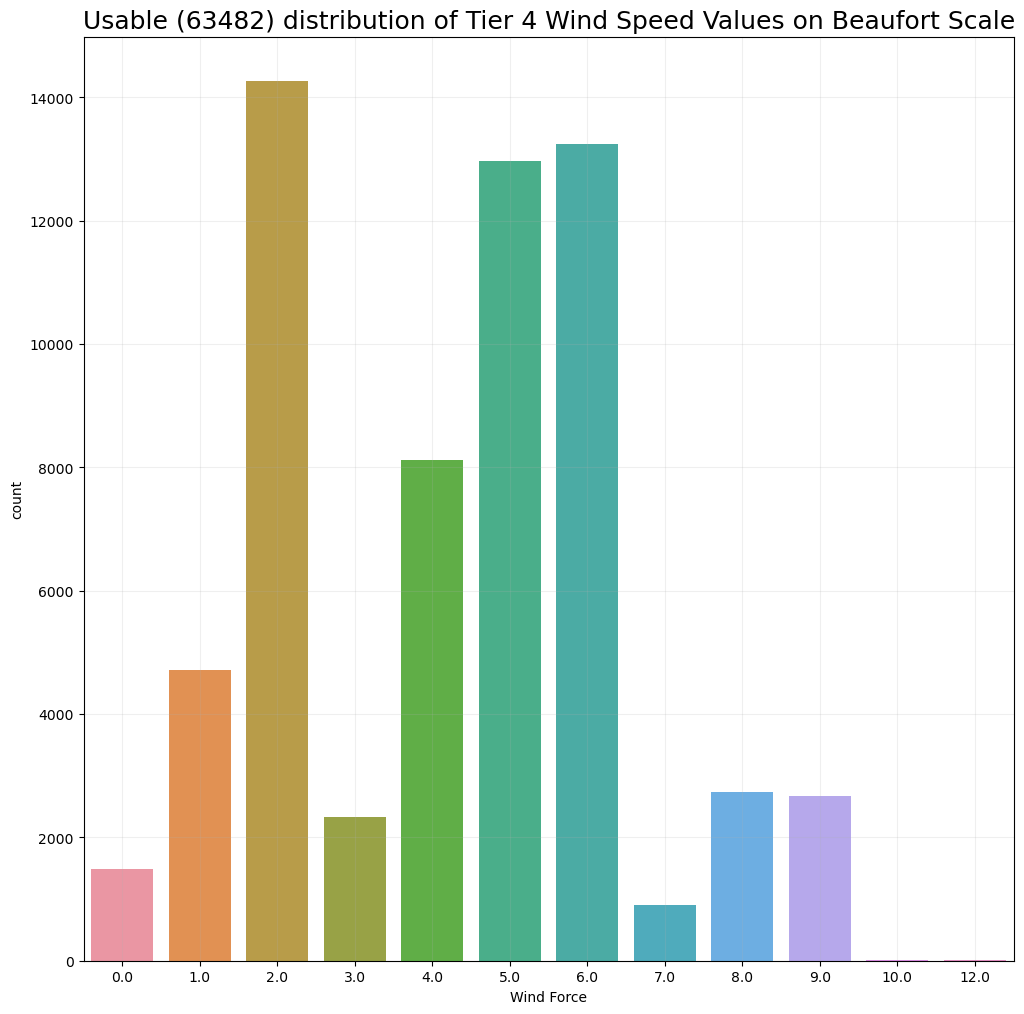

In [34]:
# Beaufort wind scale for Tier 4 usable data
num_entries = np.size(df_u4['Wind Force'])
print('Number of entries covered by the mapping so far: ',num_entries)

# Plotting the data
f, ax = plt.subplots(figsize = (12,12))
sns.countplot(x=df_u4["Wind Force"]) # Plotting Tier 4 wind force data
ax.grid(alpha=0.2) # add a light grid to background
plt.title(f'Usable ({num_entries}) distribution of Tier 4 Wind Speed Values on Beaufort Scale',fontsize=18)
plt.savefig(os.path.join(Figures, 'Tier4_Distribution_Beaufort Scale_Jun10.png'),dpi=300,bbox_inches='tight')


In [35]:
# Testing the statistical significance of this wind distribution compared to the overall 

# Mann Whitney U Test
# Non-parametric test - test that distribution x is the same as y, test of difference in location btwn dist

#Set parameters
x = df_u["Wind Force"] #overall usable wind distribution
y = df_u4["Wind Force"] #new wind distribution from infilling two days (lat&lon)

# Run Mann Whitney U Test
result_mannwhitneyu = stats.mannwhitneyu(x,y)

# Print results
print('Mann Whitney U Test:', result_mannwhitneyu)

# Kruskal_Wallis Test
# Non-parametric test - data is not assumed to be from a particular distribution

# Run Kruskal Wallis Test
result_kruskal = stats.kruskal(x,y)

# Print results
print('Kruskal-Wallis Test:', result_kruskal)

Mann Whitney U Test: MannwhitneyuResult(statistic=1914694695.0, pvalue=0.6833720619263601)
Kruskal-Wallis Test: KruskalResult(statistic=0.16635473270967888, pvalue=0.6833720026353269)


1826 :  (82, 51)
1827 :  (329, 51)
1828 :  (354, 51)
1829 :  (558, 51)
1830 :  (922, 51)
1831 :  (1033, 51)
1832 :  (944, 51)
1833 :  (919, 51)
1834 :  (990, 51)
1835 :  (1867, 51)
1836 :  (2228, 51)
1837 :  (2677, 51)
1838 :  (1938, 51)
1839 :  (1468, 51)
1840 :  (750, 51)
1841 :  (959, 51)
1842 :  (1052, 51)
1843 :  (1631, 51)
1844 :  (2021, 51)
1845 :  (2188, 51)
1846 :  (3640, 51)
1847 :  (4236, 51)
1848 :  (2923, 51)
1849 :  (2241, 51)
1850 :  (2399, 51)
1851 :  (2778, 51)
1852 :  (2595, 51)
1853 :  (1552, 51)
1854 :  (762, 51)
1855 :  (397, 51)
1856 :  (180, 51)
1857 :  (401, 51)
1858 :  (375, 51)
1859 :  (264, 51)
1860 :  (141, 51)
1861 :  (190, 51)
1862 :  (213, 51)
1863 :  (181, 51)
1864 :  (470, 51)
1865 :  (952, 51)
1866 :  (1030, 51)
1867 :  (576, 51)
1868 :  (468, 51)
1869 :  (236, 51)
1870 :  (28, 51)
1871 :  (225, 51)
1872 :  (146, 51)
1873 :  (124, 51)
1874 :  (257, 51)
1875 :  (171, 51)
1876 :  (102, 51)
1877 :  (433, 51)
1878 :  (1726, 51)
1879 :  (2005, 51)
1880 :  (

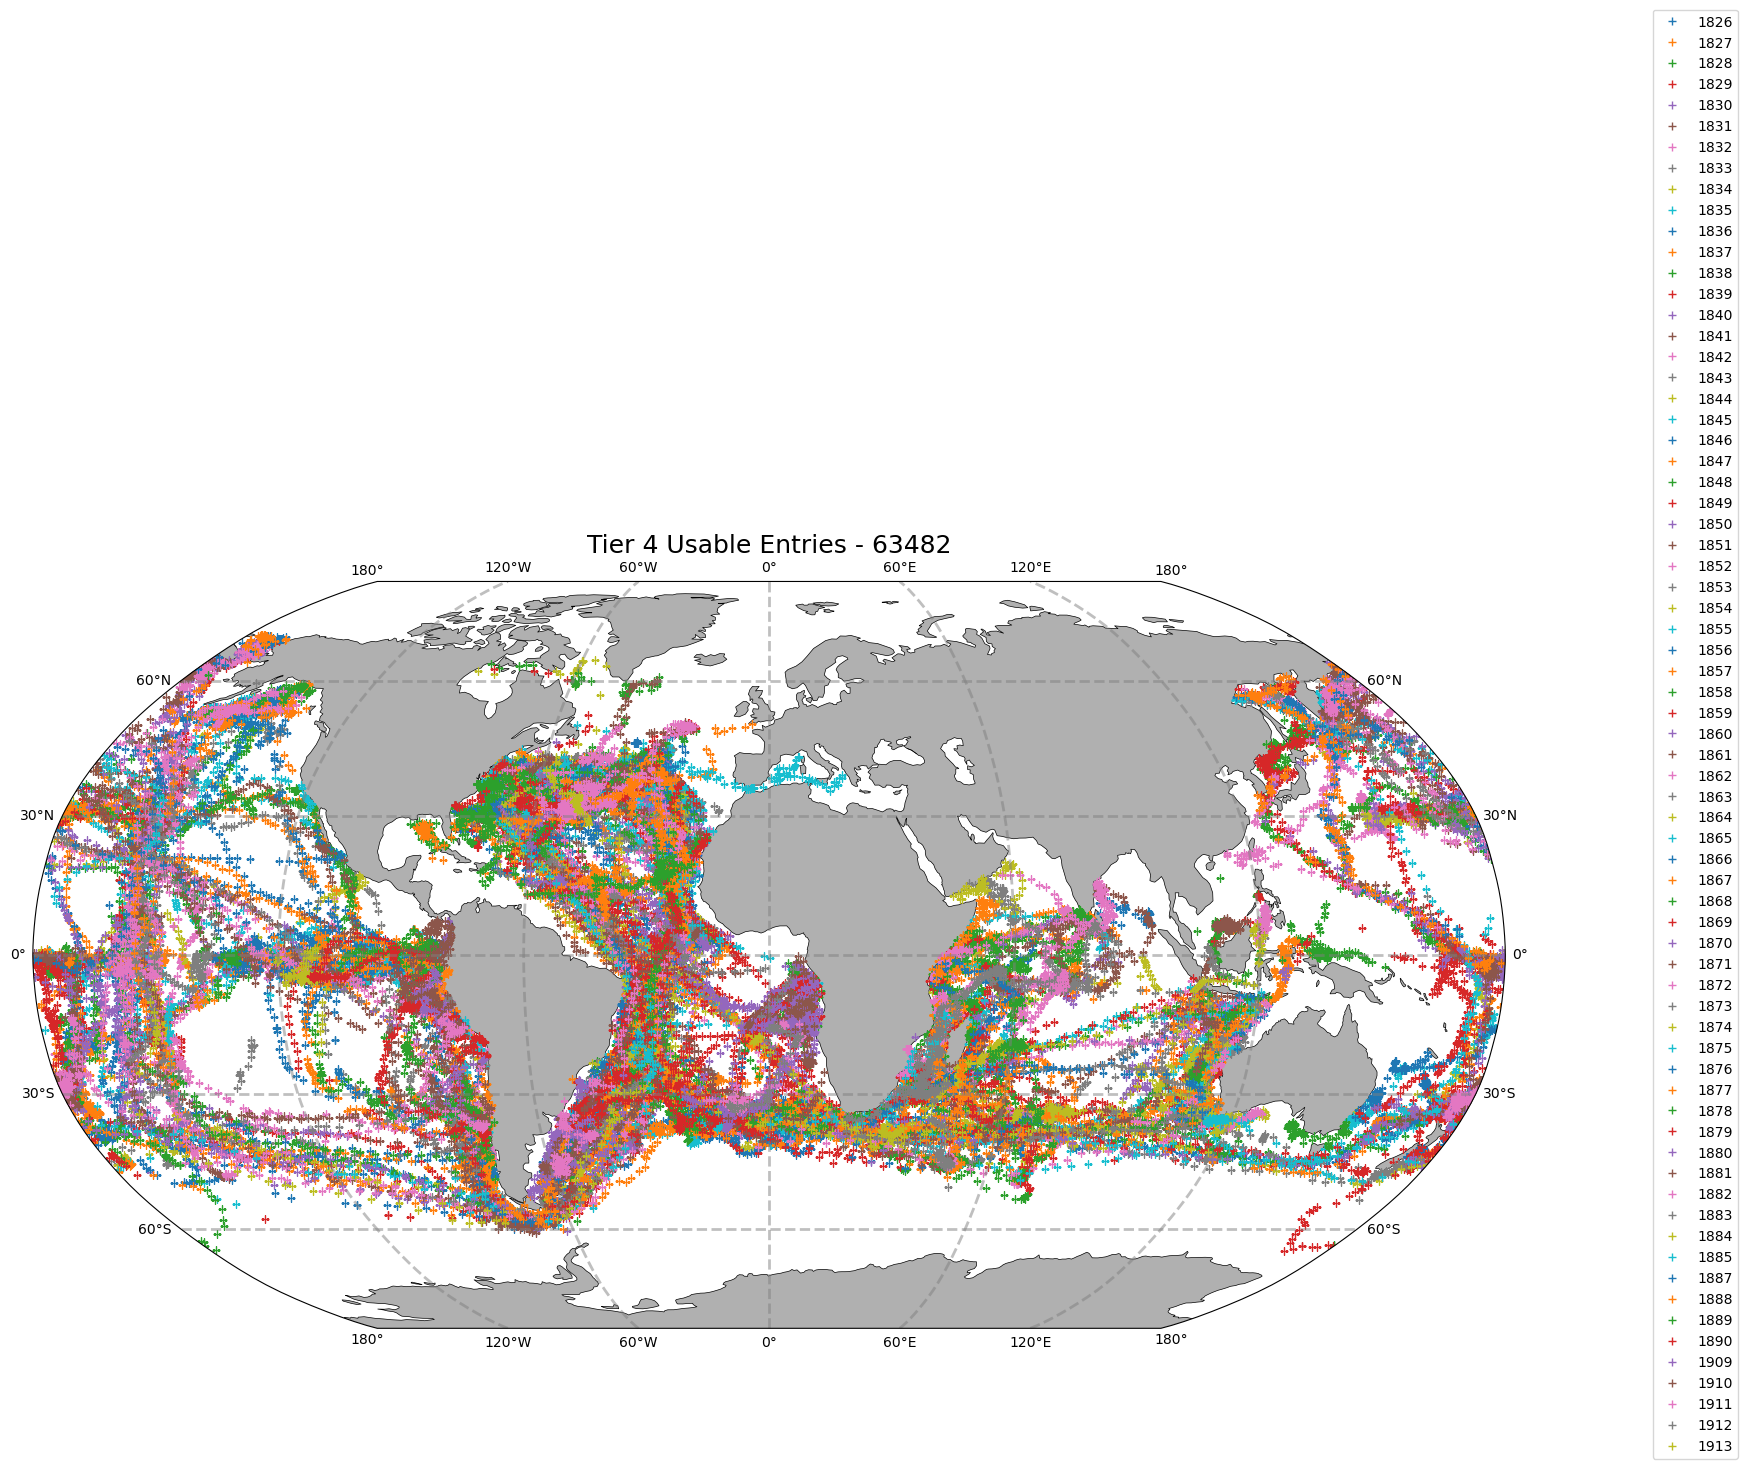

In [46]:
# Figure to plot all usable data with new infilled coordinates on a global map

# Setting up figure parameters
fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={'projection': ccrs.Robinson()})
_ = ax.set_global() # adds global map
_ = ax.coastlines(linewidth=0.5) # adds coastlines to map
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0') # adds land as grey
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--') # adds lat/lon lines

# Initialize counter for the number of plotted values
num_plotted_values = 0

# Plotting all the data with new the Tier 4 (3-5 days infilled) data color coded by year
for yr in sorted(df.loc[(df['Tier4_usable'] == True), 'Entry Date Time'].dt.year.dropna().unique()):
    work = df.loc[(df['Tier4_usable'] == True) & (df['Entry Date Time'].dt.year == yr),]
    ax.plot(work.Longitude, work.Latitude, '+', transform=ccrs.PlateCarree(), label='{:.0f}'.format(yr))
    num_plotted_values += len(work)  # Increment the counter by the number of points plotted
    print(yr, ': ', np.shape(work))

_ = ax.legend(loc=(1.1, -0.175)) # adds a legend
plt.title(f'Tier 4 Usable Entries - {num_plotted_values}', fontsize=18) # adds a title with number of entries

# Print the total number of plotted values
print("Total number of plotted values:", num_plotted_values)

# Saving the figures
fig.savefig(os.path.join(Figures, 'Tier4_Clean_up_plot_usable_Jun10.svg'), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(Figures, 'Tier4_Clean_up_plot_usable_Jun10.jpg'), dpi=300, bbox_inches='tight')


In [37]:
# Creating a dataframe of the new infilled points for this tier

df['Tier4_new'] = ((df["Latitude"].notna() & df["Longitude"].notna() & df["Wind Force"].notna()) & 
                     (df["Tier 4 Infilled"] == True))
df_new4 = df[df['Tier4_new']==True]
df_new4

,DateTime,ID,LogBook ID,Page,Latitude,Longitude,Infilled,Depth,Depth Unit,Bottom,Landmark,Ship Heading/Course,Wind Direction,Wind Speed/Force,Wind Force,Sea State,Cloud Cover,Weather,Ship Sightings,Miscellaneous Observations,wind force,Entry Date Time,Direction,Wind Direction Before,coord_diff,...,One Day Lat,One Day Lon,Tier2_usable,Tier2_new,Two Day Dist,Tier 3 Infilled,Two Day Lat,Two Day Lon,Tier3_usable,Tier3_new,Three Day Dist,Tier 4 Infilled,Day 3 Infilled,Three Day Lat,Three Day Lon,Four Day Dist,Day 4 Infilled,Four Day Lat,Four Day Lon,Five Day Dist,Day 5 Infilled,Five Day Lat,Five Day Lon,Tier4_usable,Tier4_new
96341,1853-08-23 12:00:00,2501.0,A. Houghton (bark) 1853-1857,NaN,38.700000,-30.341667,True,NaN,NaN,NaN,Island of Flores,E,0.0,light winds,2.0,NaN,NaN,squalls,NaN,NaN,False,1853-08-23 12:00:00,nan,N,False,...,NaN,NaN,False,False,NaN,NaN,NaN,NaN,False,False,171.542376,True,True,0.933333,-1.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
96340,1853-08-24 12:00:00,2502.0,A. Houghton (bark) 1853-1857,NaN,38.466667,-29.950000,True,NaN,NaN,NaN,Island of Fayal in sight,E,0.0,moderate winds,4.0,NaN,NaN,NaN,NaN,NaN,False,1853-08-24 12:00:00,nan,N,False,...,NaN,NaN,False,False,NaN,NaN,NaN,NaN,False,False,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
96338,1853-08-25 12:00:00,2503.0,A. Houghton (bark) 1853-1857,NaN,38.233333,-29.558333,True,NaN,NaN,NaN,Fayal (Faial) Island,SE,337.5,light winds,2.0,NaN,NaN,NaN,NaN,NaN,False,1853-08-25 12:00:00,nan,NNW,False,...,NaN,NaN,False,False,NaN,NaN,NaN,NaN,False,False,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
96333,1853-08-29 12:00:00,2508.0,A. Houghton (bark) 1853-1857,NaN,39.044444,-29.579167,True,NaN,NaN,NaN,Island of Flores,NNW,45.0,light winds,2.0,NaN,NaN,NaN,NaN,NaN,False,1853-08-29 12:00:00,nan,NE,False,...,NaN,NaN,False,False,NaN,True,-1.383333,NaN,False,False,NaN,True,True,NaN,-1.483333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
96332,1853-08-30 12:00:00,2510.0,A. Houghton (bark) 1853-1857,NaN,39.505556,-29.208333,True,NaN,NaN,NaN,Along the coast of the Island of Flores Close ...,NaN,45.0,moderate winds,4.0,NaN,NaN,NaN,NaN,NaN,False,1853-08-30 12:00:00,nan,NE,False,...,NaN,NaN,False,False,NaN,True,NaN,NaN,False,False,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35811,1846-07-22 12:00:00,64583.0,Yeoman (Bark) 1843-1848,NaN,34.225000,-46.166667,True,NaN,NaN,NaN,NaN,E,NaN,calm and light winds,1.0,NaN,NaN,NaN,NaN,NaN,False,1846-07-22 12:00:00,nan,NaN,False,...,-1.05,NaN,False,False,NaN,NaN,NaN,NaN,False,False,NaN,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True,True
35808,1846-07-23 12:00:00,64586.0,Yeoman (Bark) 1843-1848,NaN,34.750000,-45.733333,True,NaN,NaN,NaN,NaN,E,315.0,moderate breezes,4.0,NaN,NaN,NaN,NaN,NaN,False,1846-07-23 12:00:00,nan,NW,False,...,NaN,NaN,False,False,NaN,NaN,NaN,NaN,False,False,NaN,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True,True
35804,1846-07-25 12:00:00,64590.0,Yeoman (Bark) 1843-1848,NaN,35.233333,-45.058333,True,NaN,NaN,NaN,NaN,NaN,NaN,moderate breezes,4.0,NaN,NaN,fine weather,NaN,NaN,False,1846-07-25 12:00:00,nan,NaN,False,...,NaN,NaN,False,False,NaN,NaN,NaN,NaN,False,False,NaN,True,True,NaN,-0.966667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
34823,1846-07-27 12:00:00,65587.0,Yeoman (Bark) 1843-1848,NaN,35.300000,-44.575000,True,NaN,NaN,NaN,NaN,S,270.0,strong breezes,6.0,NaN,NaN,NaN,NaN,NaN,False,1846-07-27 12:00:00,nan,W,False,...,NaN,NaN,False,False,NaN,NaN,NaN,NaN,False,False,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True


Total number of plotted values: 63482


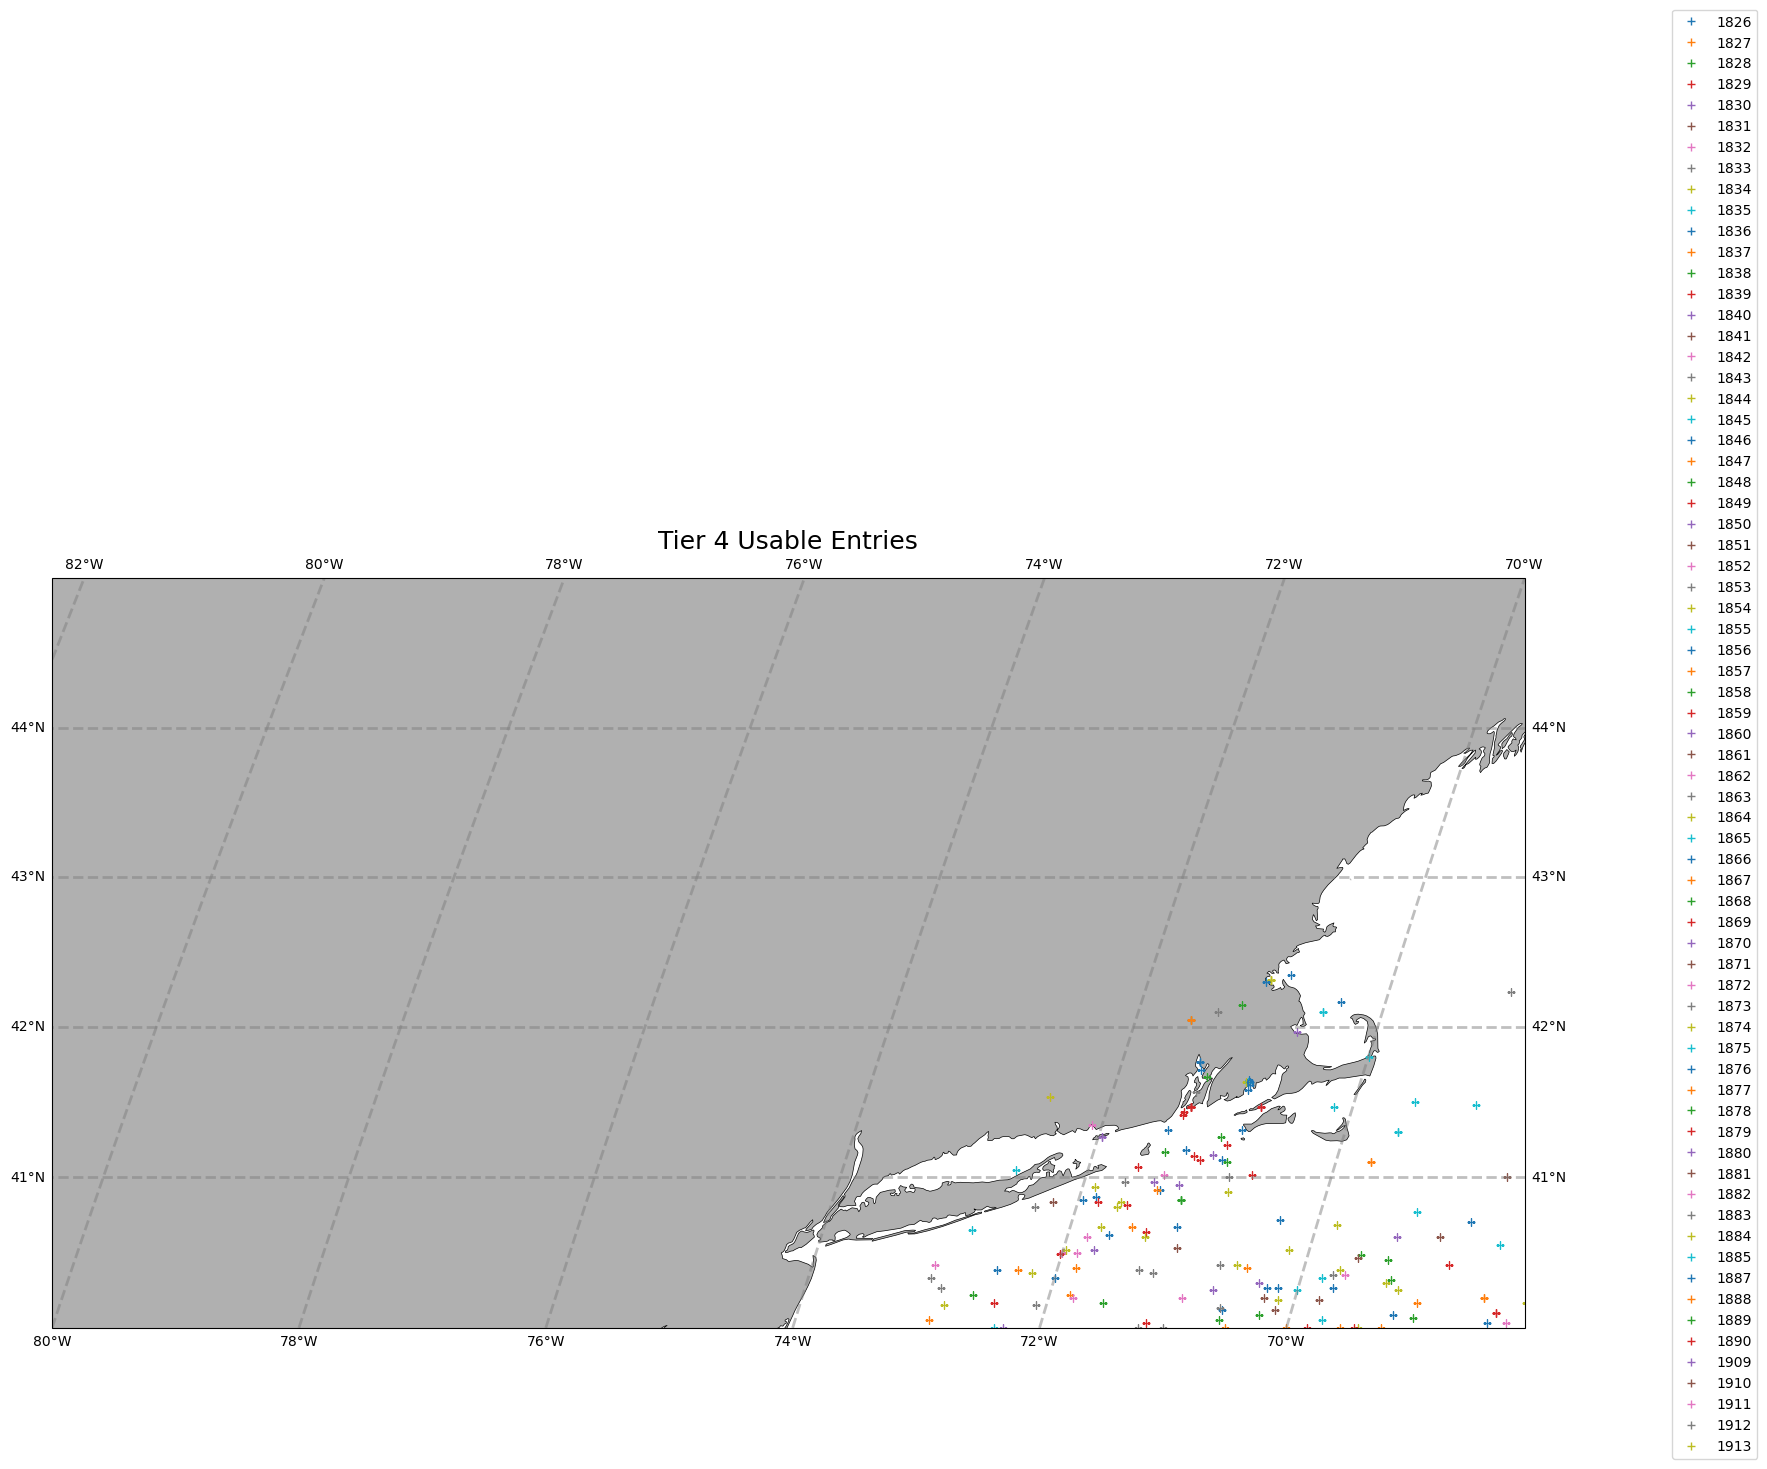

In [38]:
# Plotting all data with extents set to find points over land 
# Or points that look wrong, stand by themself in the global ocean

# Set Extent
extent = [-80, -70, 40, 45]
# extent = [minimum longitude, maximum longitude, minimum latitude, maximum latitude]

# Setting up figure parameters
fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={'projection': ccrs.Robinson()})
#_ = ax.set_global()
_ = ax.set_extent(extent, crs=ccrs.PlateCarree())
_ = ax.coastlines(linewidth=0.5)
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Initialize counter for the number of plotted values
num_plotted_values = 0

# Plotting the data
for yr in sorted(df.loc[(df['Tier4_usable'] == True), 'Entry Date Time'].dt.year.dropna().unique()):
    work = df.loc[(df['Tier4_usable'] == True) & (df['Entry Date Time'].dt.year == yr),]
    ax.plot(work.Longitude, work.Latitude, '+', transform=ccrs.PlateCarree(), label='{:.0f}'.format(yr))
    num_plotted_values += len(work)  # Increment the counter by the number of points plotted
    #print(yr, ': ', np.shape(work))

_ = ax.legend(loc=(1.1, -0.175))
plt.title('Tier 4 Usable Entries', fontsize=18)

# Print the total number of plotted values
print("Total number of plotted values:", num_plotted_values)

In [39]:
#Finding the logbook ID, ID, and coordinates of flagged data

# Filter the DataFrame based on latitude and longitude ranges
filtered_df = df[
    (df['Latitude'] >= 40) & (df['Latitude'] <= 41) & 
    (df['Longitude'] >= -80) & (df['Longitude'] <= -78)
]

# Display the filtered DataFrame
print(filtered_df[['LogBook ID', 'ID', 'Latitude', 'Longitude']])

Empty DataFrame
Columns: [LogBook ID, ID, Latitude, Longitude]
Index: []


1827 :  (32, 51)
1828 :  (3, 51)
1829 :  (3, 51)
1830 :  (36, 51)
1831 :  (13, 51)
1833 :  (30, 51)
1834 :  (73, 51)
1835 :  (113, 51)
1836 :  (123, 51)
1837 :  (97, 51)
1838 :  (60, 51)
1839 :  (62, 51)
1840 :  (26, 51)
1841 :  (37, 51)
1842 :  (75, 51)
1843 :  (169, 51)
1844 :  (132, 51)
1845 :  (165, 51)
1846 :  (201, 51)
1847 :  (166, 51)
1848 :  (242, 51)
1849 :  (109, 51)
1850 :  (119, 51)
1851 :  (91, 51)
1852 :  (121, 51)
1853 :  (28, 51)
1854 :  (10, 51)
1855 :  (8, 51)
1856 :  (6, 51)
1857 :  (47, 51)
1858 :  (64, 51)
1859 :  (20, 51)
1861 :  (11, 51)
1862 :  (27, 51)
1863 :  (11, 51)
1864 :  (9, 51)
1865 :  (64, 51)
1866 :  (72, 51)
1867 :  (32, 51)
1868 :  (30, 51)
1869 :  (1, 51)
1871 :  (10, 51)
1872 :  (10, 51)
1873 :  (3, 51)
1874 :  (8, 51)
1875 :  (15, 51)
1877 :  (7, 51)
1878 :  (49, 51)
1879 :  (53, 51)
1880 :  (66, 51)
1881 :  (20, 51)
1882 :  (31, 51)
1883 :  (9, 51)
1884 :  (21, 51)
1885 :  (10, 51)
1889 :  (6, 51)
1890 :  (5, 51)
1911 :  (3, 51)
1912 :  (12, 51)

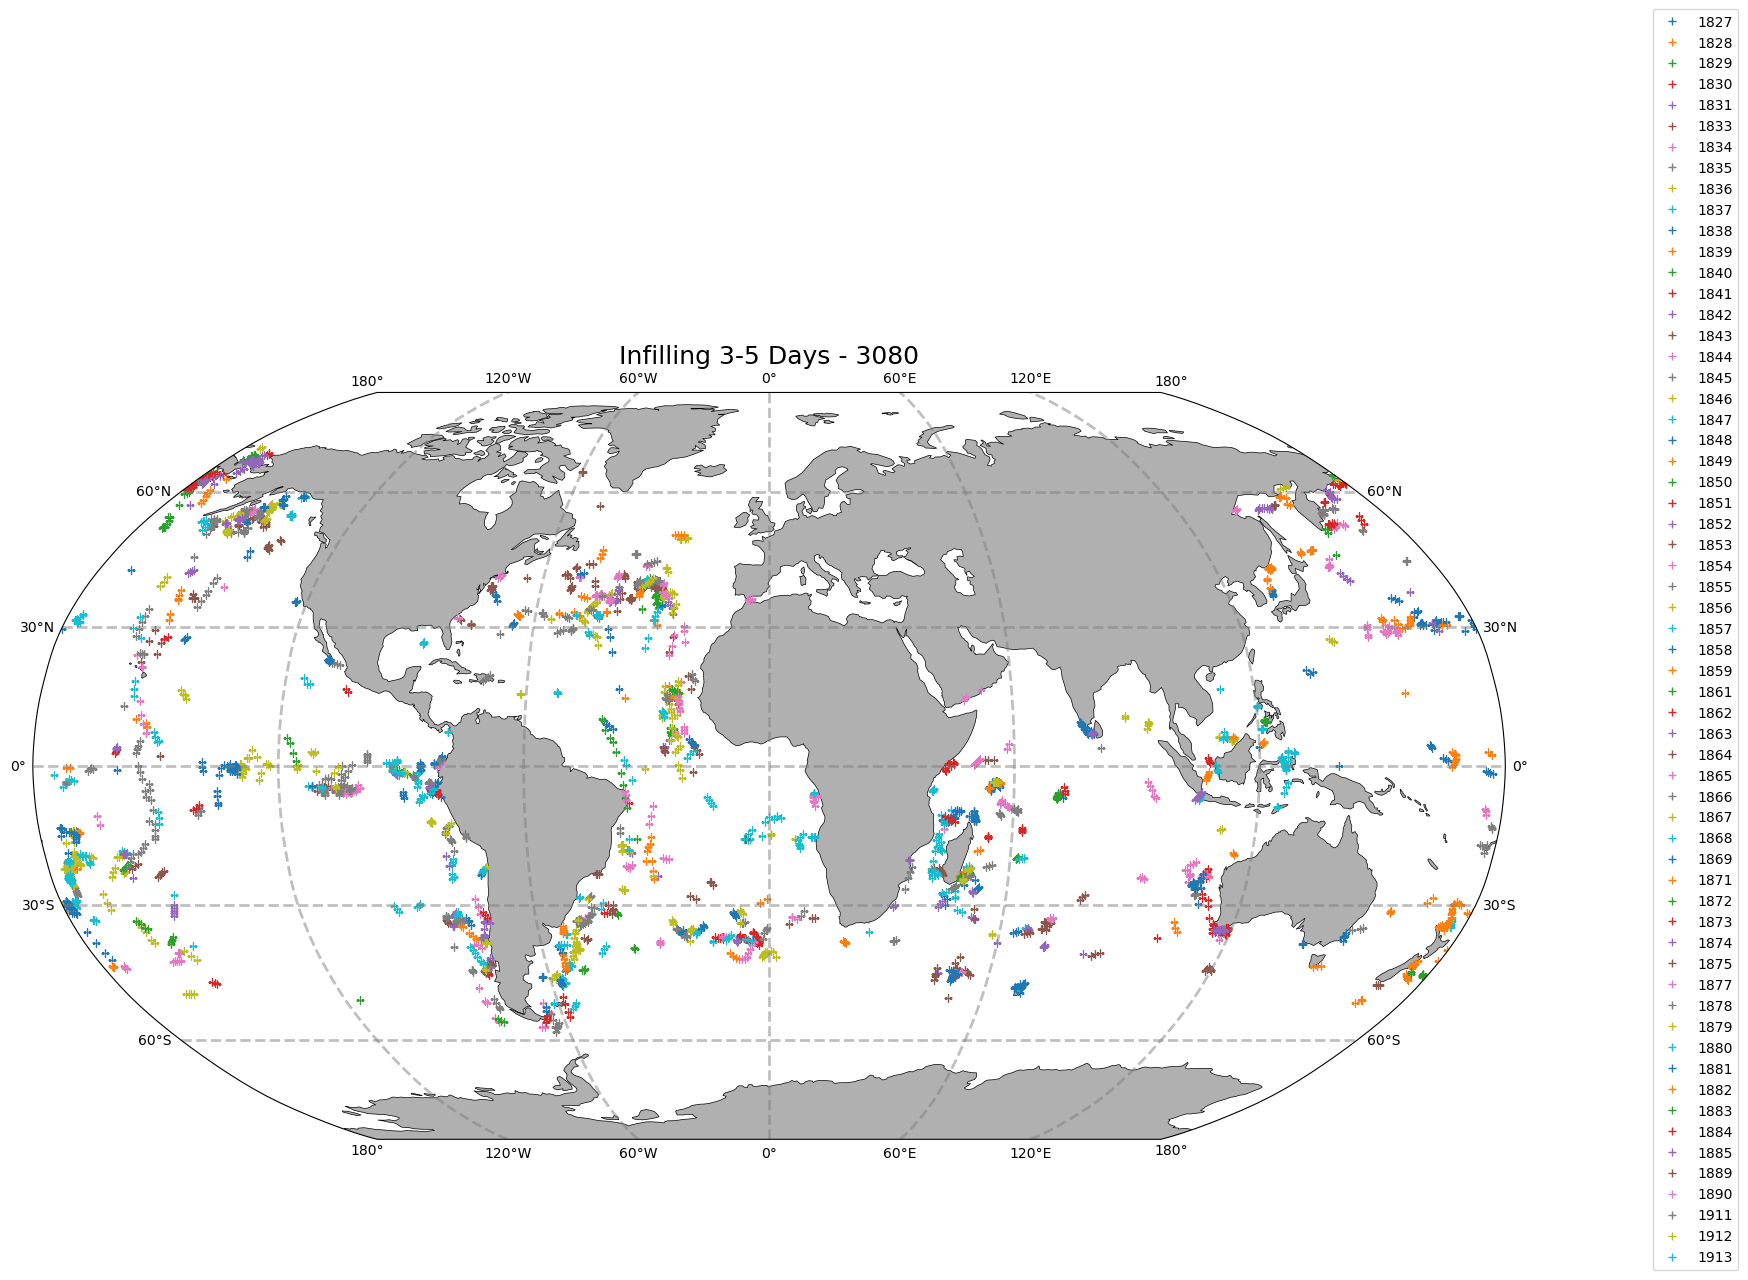

In [48]:
# Figure to plot new infilled tier 4 coordinates on a global map

# Setting up figure parameters
fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={'projection': ccrs.Robinson()})
_ = ax.set_global()
_ = ax.coastlines(linewidth=0.5)
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Initialize counter for the number of plotted values
num_plotted_values = 0

# Plotting only the new tier 4 3-5 days infilled values color coded by year 
for yr in sorted(df.loc[(df['Tier4_new'] == True), 'Entry Date Time'].dt.year.dropna().unique()):
    work = df.loc[(df['Tier4_new'] == True) & (df['Entry Date Time'].dt.year == yr),]
    ax.plot(work.Longitude, work.Latitude, '+', transform=ccrs.PlateCarree(), label='{:.0f}'.format(yr))
    num_plotted_values += len(work)  # Increment the counter by the number of points plotted
    print(yr, ': ', np.shape(work))

_ = ax.legend(loc=(1.1, -0.175))
plt.title(f'Infilling 3-5 Days - {num_plotted_values}', fontsize=18)

# Print the total number of plotted values
print("Total number of plotted values:", num_plotted_values)

# Saving the figures
fig.savefig(os.path.join(Figures, 'Tier4_Infilled_Jun10.svg'), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(Figures, 'Tier4_Infilled_Jun10.jpg'), dpi=300, bbox_inches='tight')


In [41]:
# Creating a dataframe of the new infilled points by day for this tier

# Infilling three days df
df['Day 3'] = ((df["Latitude"].notna() & df["Longitude"].notna() & df["Wind Force"].notna()) & 
                     (df["Day 3 Infilled"] == True))
df_day3 = df[df['Day 3']==True]
print('3 Days:', len(df_day3))

# Infilling four days df
df['Day 4'] = ((df["Latitude"].notna() & df["Longitude"].notna() & df["Wind Force"].notna()) & 
                     (df["Day 4 Infilled"] == True))
df_day4 = df[df['Day 4']==True]
print('4 Days:', len(df_day4))

# Infilling five days df
df['Day 5'] = ((df["Latitude"].notna() & df["Longitude"].notna() & df["Wind Force"].notna()) & 
                     (df["Day 5 Infilled"] == True))
df_day5 = df[df['Day 5']==True]
print('5 Days:', len(df_day5))

3 Days: 1472
4 Days: 1110
5 Days: 693


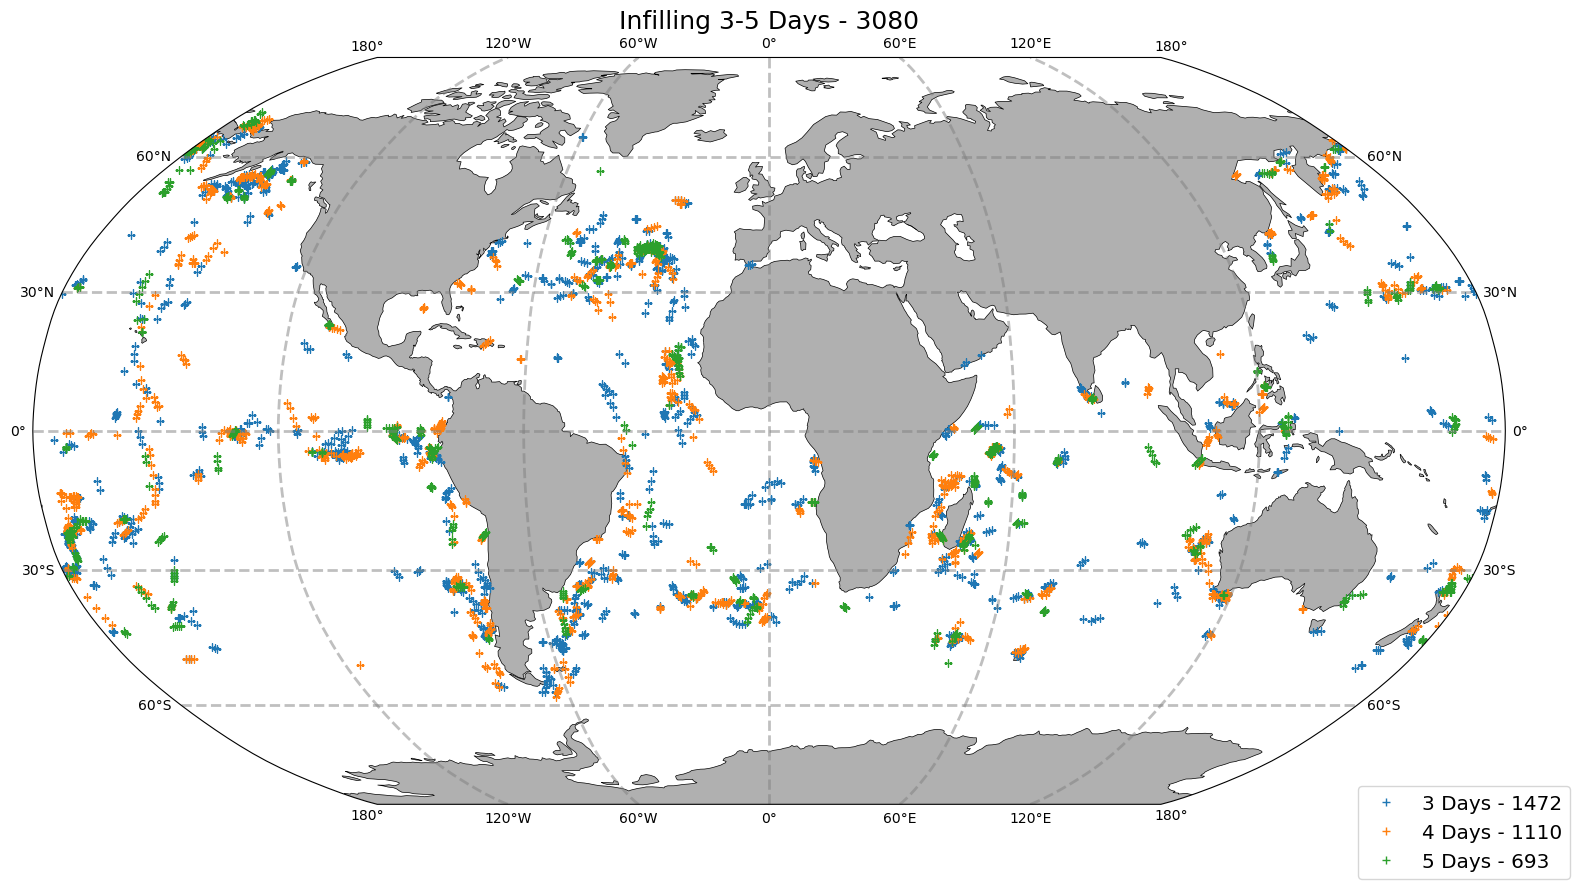

In [42]:
# Figure to plot new infilled coordinates by day on a global map

# Setting up figure parameters
fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={'projection': ccrs.Robinson()})
_ = ax.set_global()
_ = ax.coastlines(linewidth=0.5)
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Plotting the data
# Infilling 3 days
_ = ax.plot(df_day3['Longitude'], df_day3['Latitude'], '+', \
        	transform=ccrs.PlateCarree(), label=f'3 Days - {len(df_day3)}')
# Infilling 4 days
_ = ax.plot(df_day4['Longitude'], df_day4['Latitude'], '+', \
        	transform=ccrs.PlateCarree(), label=f'4 Days - {len(df_day4)}')
# Infilling 5 days
_ = ax.plot(df_day5['Longitude'], df_day5['Latitude'], '+', \
        	transform=ccrs.PlateCarree(), label=f'5 Days - {len(df_day5)}')

_ = ax.legend(loc=(0.90, -0.10), fontsize = 'x-large') # adds a legend
plt.title(f'Infilling 3-5 Days - {num_plotted_values}', fontsize=18) # adds a title

# Saving the figures
fig.savefig(os.path.join(Figures, 'Tier4_Infilled_by_day_Jun10.jpg'), dpi=300, bbox_inches='tight')


In [43]:
# Dropping the extra infilling columns
columns_to_drop = ['Day 3 Infilled', 'Day 4 Infilled', 'Day 5 Infilled', 'Day 3', 'Day 4', 'Day 5']
df.drop(columns = columns_to_drop, inplace = True)

### Save data to CSV

In [44]:
df.to_csv(os.path.join(CSV, 'Tier4_logentries-export-2024-06-10.csv'), index = False) #.csv file seems unreadable, don't know what the issue is: using pickle instead
df.to_pickle("Tier4_logentries-export-2024-06-10.pkl") # save data to a pkl file 
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 96383 entries, 12264 to 21835
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   DateTime                    96378 non-null  object        
 1   ID                          96380 non-null  float64       
 2   LogBook ID                  96379 non-null  object        
 3   Page                        59413 non-null  float64       
 4   Latitude                    79960 non-null  float64       
 5   Longitude                   71985 non-null  float64       
 6   Infilled                    96383 non-null  bool          
 7   Depth                       2134 non-null   float64       
 8   Depth Unit                  22937 non-null  object        
 9   Bottom                      63 non-null     object        
 10  Landmark                    15197 non-null  object        
 11  Ship Heading/Course         53219 non-null  object     

,DateTime,ID,LogBook ID,Page,Latitude,Longitude,Infilled,Depth,Depth Unit,Bottom,Landmark,Ship Heading/Course,Wind Direction,Wind Speed/Force,Wind Force,Sea State,Cloud Cover,Weather,Ship Sightings,Miscellaneous Observations,wind force,Entry Date Time,Direction,Wind Direction Before,coord_diff,...,usable_latlon,usable_lat,One Day Dist,One Day Lat,One Day Lon,Tier2_usable,Tier2_new,Two Day Dist,Tier 3 Infilled,Two Day Lat,Two Day Lon,Tier3_usable,Tier3_new,Three Day Dist,Tier 4 Infilled,Three Day Lat,Three Day Lon,Four Day Dist,Four Day Lat,Four Day Lon,Five Day Dist,Five Day Lat,Five Day Lon,Tier4_usable,Tier4_new
12264,4.5,4.5,4.5,4.5,NaN,NaN,False,4.5,4.5,4.5,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaT,nan,NaN,False,...,False,False,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
12266,10,10.0,10,10.0,NaN,NaN,False,10.0,10,10,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaT,nan,NaN,False,...,False,False,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
96400,1853-07-06 12:00:00,2442.0,A. Houghton (bark) 1853-1857,NaN,37.85,-58.466667,False,NaN,NaN,NaN,NaN,SE,225.0,moderate gales,7.0,NaN,NaN,NaN,NaN,NaN,False,1853-07-06 12:00:00,nan,SW,False,...,True,True,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
96398,1853-07-07 12:00:00,2443.0,A. Houghton (bark) 1853-1857,NaN,37.25,-55.066667,False,NaN,NaN,NaN,NaN,NaN,225.0,fresh breezes,5.0,NaN,NaN,NaN,NaN,NaN,False,1853-07-07 12:00:00,nan,SW,False,...,True,True,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
96397,1853-07-08 12:00:00,2445.0,A. Houghton (bark) 1853-1857,NaN,35.00,-53.400000,False,NaN,NaN,NaN,NaN,SE,NaN,NaN,NaN,NaN,NaN,fine,NaN,NaN,False,1853-07-08 12:00:00,nan,NaN,False,...,True,True,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
